In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from tqdm import tqdm

import requests
from bs4 import BeautifulSoup
from io import StringIO

from data.omni import OMNI
from data.wsa_enlil import WSA_ENLIL
from data.eswf3_2 import ESWF3_2
from data.dl_model import DL_Model
from data.persistence import Persistence_3days, Persistence_4days, Persistence_5days, Persistence_27days

from scipy.stats import pearsonr

import skill_metrics as sm
from matplotlib import rcParams

## ICME Events

In [2]:
# ICME event list URL
ICME_url = "https://izw1.caltech.edu/ACE/ASC/DATA/level3/icmetable2.htm"
response = requests.get(ICME_url)

if response.status_code == 200:
    soup = BeautifulSoup(response.content, 'html.parser')
    table = soup.find('table')
    icme = pd.read_html(StringIO(str(table)))[0]



    # select the columns (ICME_start, ICME_end, ICME_mean, ICME_max)
    icme = icme.iloc[:, [1, 2, 11, 12]]
    icme.columns = ["ICME_start", "ICME_end", "ICME_mean", "ICME_max"]
    icme = icme.dropna(subset=["ICME_start", "ICME_end"])

    for col in ["ICME_start", "ICME_end"]:
        icme[col] = pd.to_datetime(icme[col],
                                   format="%Y/%m/%d %H%M",
                                   errors="coerce")

    t0 = pd.Timestamp("2012-10-01")
    t1 = pd.Timestamp("2020-12-31 23:59")
    mask = (
        icme['ICME_start'].dt.year.between(2012, 2020) &
        icme['ICME_start'].dt.month.isin([10, 11, 12]) &
        icme['ICME_end']  .dt.year.between(2012, 2020) &
        icme['ICME_end']  .dt.month.isin([10, 11, 12])
    )
    icme = icme.loc[mask].reset_index(drop=True)


    # 6) [(start_str, end_str), …] 형태의 리스트로
    icme_event_list = icme[["ICME_start", "ICME_end"]].apply(
        lambda r: [r["ICME_start"].strftime("%Y-%m-%d %H:%M"),
                   r["ICME_end"].strftime("%Y-%m-%d %H:%M")],
        axis=1
    ).tolist()

else:
    print(f"Request failed with status code: {response.status_code}")

print("Number of ICME events:", len(icme_event_list))
icme_event_list

Number of ICME events: 32


[['2012-10-01 00:00', '2012-10-02 00:00'],
 ['2012-10-02 22:00', '2012-10-03 06:00'],
 ['2012-10-08 18:00', '2012-10-09 12:00'],
 ['2012-10-12 22:00', '2012-10-13 10:00'],
 ['2012-11-01 00:00', '2012-11-02 03:00'],
 ['2012-11-09 03:00', '2012-11-09 15:00'],
 ['2012-11-13 08:00', '2012-11-14 03:00'],
 ['2012-11-24 12:00', '2012-11-25 10:00'],
 ['2012-11-26 12:00', '2012-11-28 05:00'],
 ['2012-11-28 18:00', '2012-11-29 14:00'],
 ['2012-12-14 07:00', '2012-12-14 17:00'],
 ['2013-10-02 23:00', '2013-10-03 22:00'],
 ['2013-10-09 09:00', '2013-10-11 00:00'],
 ['2013-11-08 22:00', '2013-11-09 07:00'],
 ['2013-11-11 17:00', '2013-11-12 03:00'],
 ['2013-12-01 11:00', '2013-12-02 23:00'],
 ['2013-12-15 16:00', '2013-12-16 05:00'],
 ['2013-12-25 05:00', '2013-12-25 17:00'],
 ['2014-11-11 07:00', '2014-11-11 20:00'],
 ['2014-12-22 04:00', '2014-12-22 17:00'],
 ['2015-10-25 14:00', '2015-10-27 04:00'],
 ['2015-11-04 15:00', '2015-11-04 19:00'],
 ['2015-11-07 06:00', '2015-11-08 16:00'],
 ['2015-12-

---

## Statistical Verification

### MAE

In [3]:
all_CR_list = [2128, 2129, 2130, 2131, 2132,
               2142, 2143, 2144, 2145, 2155, 2156, 2157, 2158, 
               2168, 2169, 2170, 2171, 2172, 2182, 2183, 2184, 2185, 2195, 2196, 2197, 2198, 2199, 2209, 2210, 2211, 2212, 
               2222, 2223, 2224, 2225, 2235, 2236, 2237, 2238, 2239]

ascending_CR_list = [2128, 2129, 2130, 2131, 2132]
maximum_CR_list = [2142, 2143, 2144, 2145, 2155, 2156, 2157, 2158]
descending_CR_list = [2168, 2169, 2170, 2171, 2172, 2182, 2183, 2184, 2185, 2195, 2196, 2197, 2198, 2199, 2209, 2210, 2211, 2212]
minimum_CR_list = [2222, 2223, 2224, 2225, 2235, 2236, 2237, 2238, 2239]

model_mae = 0
wsa_mae = 0
eswf_mae = 0

persistence_3days_mae = 0
persistence_4days_mae = 0
persistence_5days_mae = 0
persistence_27days_mae = 0

model_n = 0
wsa_n = 0
eswf_n = 0

persistence_3days_n = 0
persistence_4days_n = 0
persistence_5days_n = 0
persistence_27days_n = 0

def MAE(omni, model, valid_index):
    omni = np.array(omni)
    model = np.array(model)
    
    errors = omni[valid_index] - model[valid_index]
    error_sum = np.sum(np.abs(errors))
    n = len(errors)
    return error_sum, n

for CR_lists in [all_CR_list, ascending_CR_list, maximum_CR_list, descending_CR_list, minimum_CR_list]:
    for CR in tqdm(CR_lists):
        _, omni_speeds = OMNI(CR)
        _, wsa_speeds = WSA_ENLIL(CR)
        _, eswf3_2speeds = ESWF3_2(CR)
        _, model_speeds = DL_Model(CR)

        _, persistence_3days_speeds = Persistence_3days(CR)
        _, persistence_4days_speeds = Persistence_4days(CR)
        _, persistence_5days_speeds = Persistence_5days(CR)
        _, persistence_27days_speeds = Persistence_27days(CR)
    
        valid_index1 = ~np.isnan(omni_speeds) & ~np.isnan(model_speeds) & ~np.isnan(wsa_speeds) & ~np.isnan(eswf3_2speeds)
        valid_index2 = ~np.isnan(persistence_3days_speeds) & ~np.isnan(persistence_4days_speeds) \
                     & ~np.isnan(persistence_5days_speeds) & ~np.isnan(persistence_27days_speeds)
        
        valid_index = valid_index1 & valid_index2

        # 사용자 모델에 대한 MAE 계산
        model_error_sum, model_count = MAE(omni_speeds, model_speeds, valid_index)
        model_mae += model_error_sum
        model_n += model_count

        # WSA 모델에 대한 MAE 계산
        wsa_error_sum, wsa_count = MAE(omni_speeds, wsa_speeds, valid_index)
        wsa_mae += wsa_error_sum
        wsa_n += wsa_count
    
        # ESWF3_2 모델에 대한 MAE 계산
        eswf_error_sum, eswf_count = MAE(omni_speeds, eswf3_2speeds, valid_index)
        eswf_mae += eswf_error_sum
        eswf_n += eswf_count

        # Persistence 모델에 대한 MAE 계산
        persistence_3days_error_sum, persistence_3days_count = MAE(omni_speeds, persistence_3days_speeds, valid_index)
        persistence_3days_mae += persistence_3days_error_sum
        persistence_3days_n += persistence_3days_count

        persistence_4days_error_sum, persistence_4days_count = MAE(omni_speeds, persistence_4days_speeds, valid_index)
        persistence_4days_mae += persistence_4days_error_sum
        persistence_4days_n += persistence_4days_count

        persistence_5days_error_sum, persistence_5days_count = MAE(omni_speeds, persistence_5days_speeds, valid_index)
        persistence_5days_mae += persistence_5days_error_sum
        persistence_5days_n += persistence_5days_count

        persistence_27days_error_sum, persistence_27days_count = MAE(omni_speeds, persistence_27days_speeds, valid_index)
        persistence_27days_mae += persistence_27days_error_sum
        persistence_27days_n += persistence_27days_count

    print("model: {} km/s".format(np.round(model_mae/model_n, 4)))
    print("wsa: {} km/s".format(np.round(wsa_mae/wsa_n, 1)))
    print("eswf: {} km/s".format(np.round(eswf_mae/eswf_n, 1)))

    print("persistence_3days: {} km/s".format(np.round(persistence_3days_mae/persistence_3days_n, 1)))
    print("persistence_4days: {} km/s".format(np.round(persistence_4days_mae/persistence_4days_n, 1)))
    print("persistence_5days: {} km/s".format(np.round(persistence_5days_mae/persistence_5days_n, 1)))
    print("persistence_27days: {} km/s".format(np.round(persistence_27days_mae/persistence_27days_n, 1)), '\n')

    model_mae, wsa_mae, eswf_mae = 0, 0, 0
    model_n, wsa_n, eswf_n = 0, 0, 0

    persistence_3days_mae, persistence_4days_mae, persistence_5days_mae, persistence_27days_mae = 0, 0, 0, 0
    persistence_3days_n, persistence_4days_n, persistence_5days_n, persistence_27days_n = 0, 0, 0, 0

100%|██████████| 40/40 [08:09<00:00, 12.24s/it]


model: 51.4249 km/s
wsa: 86.9 km/s
eswf: 100.4 km/s
persistence_3days: 90.1 km/s
persistence_4days: 96.7 km/s
persistence_5days: 99.7 km/s
persistence_27days: 65.2 km/s 



100%|██████████| 5/5 [00:52<00:00, 10.49s/it]


model: 57.737 km/s
wsa: 67.8 km/s
eswf: 73.9 km/s
persistence_3days: 63.4 km/s
persistence_4days: 65.9 km/s
persistence_5days: 69.9 km/s
persistence_27days: 67.1 km/s 



100%|██████████| 8/8 [01:51<00:00, 13.95s/it]


model: 60.529 km/s
wsa: 98.0 km/s
eswf: 91.5 km/s
persistence_3days: 82.6 km/s
persistence_4days: 85.8 km/s
persistence_5days: 84.6 km/s
persistence_27days: 64.1 km/s 



100%|██████████| 18/18 [03:38<00:00, 12.15s/it]


model: 50.9328 km/s
wsa: 86.1 km/s
eswf: 117.4 km/s
persistence_3days: 107.6 km/s
persistence_4days: 116.9 km/s
persistence_5days: 120.4 km/s
persistence_27days: 68.3 km/s 



100%|██████████| 9/9 [01:49<00:00, 12.13s/it]

model: 41.7413 km/s
wsa: 86.8 km/s
eswf: 86.5 km/s
persistence_3days: 74.3 km/s
persistence_4days: 80.3 km/s
persistence_5days: 85.4 km/s
persistence_27days: 59.5 km/s 



### RMSE

In [4]:
all_CR_list = [2128, 2129, 2130, 2131, 2132,
               2142, 2143, 2144, 2145, 2155, 2156, 2157, 2158, 
               2168, 2169, 2170, 2171, 2172, 2182, 2183, 2184, 2185, 2195, 2196, 2197, 2198, 2199, 2209, 2210, 2211, 2212, 
               2222, 2223, 2224, 2225, 2235, 2236, 2237, 2238, 2239]

ascending_CR_list = [2128, 2129, 2130, 2131, 2132]
maximum_CR_list = [2142, 2143, 2144, 2145, 2155, 2156, 2157, 2158]
descending_CR_list = [2168, 2169, 2170, 2171, 2172, 2182, 2183, 2184, 2185, 2195, 2196, 2197, 2198, 2199, 2209, 2210, 2211, 2212]
minimum_CR_list = [2222, 2223, 2224, 2225, 2235, 2236, 2237, 2238, 2239]

model_mse = 0
wsa_mse = 0
eswf_mse = 0

persistence_3days_mse = 0
persistence_4days_mse = 0
persistence_5days_mse = 0
persistence_27days_mse = 0

model_n = 0
wsa_n = 0
eswf_n = 0

persistence_3days_n = 0
persistence_4days_n = 0
persistence_5days_n = 0
persistence_27days_n = 0

def MSE(omni, model, valid_index):
    omni = np.array(omni)
    model = np.array(model)
    
    errors = omni[valid_index] - model[valid_index]
    error_sum = np.sum(errors ** 2)
    n = len(errors)
    return error_sum, n

for CR_lists in [all_CR_list, ascending_CR_list, maximum_CR_list, descending_CR_list, minimum_CR_list]:
    for CR in tqdm(CR_lists):
        _, omni_speeds = OMNI(CR)
        _, wsa_speeds = WSA_ENLIL(CR)
        _, eswf3_2speeds = ESWF3_2(CR)
        _, model_speeds = DL_Model(CR)

        _, persistence_3days_speeds = Persistence_3days(CR)
        _, persistence_4days_speeds = Persistence_4days(CR)
        _, persistence_5days_speeds = Persistence_5days(CR)
        _, persistence_27days_speeds = Persistence_27days(CR)

        valid_index1 = ~np.isnan(omni_speeds) & ~np.isnan(model_speeds) & ~np.isnan(wsa_speeds) & ~np.isnan(eswf3_2speeds)
        valid_index2 = ~np.isnan(persistence_3days_speeds) & ~np.isnan(persistence_4days_speeds) \
                     & ~np.isnan(persistence_5days_speeds) & ~np.isnan(persistence_27days_speeds)
        valid_index = valid_index1 & valid_index2

        # 사용자 모델에 대한 MSE 계산
        model_error_sum, model_count = MSE(omni_speeds, model_speeds, valid_index)
        model_mse += model_error_sum
        model_n += model_count
        
        # WSA 모델에 대한 MSE 계산
        wsa_error_sum, wsa_count = MSE(omni_speeds, wsa_speeds, valid_index)
        wsa_mse += wsa_error_sum
        wsa_n += wsa_count
    
        # ESWF3_2 모델에 대한 MSE 계산
        eswf_error_sum, eswf_count = MSE(omni_speeds, eswf3_2speeds, valid_index)
        eswf_mse += eswf_error_sum
        eswf_n += eswf_count

        # Persistence 모델에 대한 MSE 계산
        persistence_3days_error_sum, persistence_3days_count = MSE(omni_speeds, persistence_3days_speeds, valid_index)
        persistence_3days_mse += persistence_3days_error_sum
        persistence_3days_n += persistence_3days_count

        persistence_4days_error_sum, persistence_4days_count = MSE(omni_speeds, persistence_4days_speeds, valid_index)
        persistence_4days_mse += persistence_4days_error_sum
        persistence_4days_n += persistence_4days_count

        persistence_5days_error_sum, persistence_5days_count = MSE(omni_speeds, persistence_5days_speeds, valid_index)
        persistence_5days_mse += persistence_5days_error_sum
        persistence_5days_n += persistence_5days_count

        persistence_27days_error_sum, persistence_27days_count = MSE(omni_speeds, persistence_27days_speeds, valid_index)
        persistence_27days_mse += persistence_27days_error_sum
        persistence_27days_n += persistence_27days_count

    # RMSE 계산
    print("model: {} km/s".format(np.round(np.sqrt(model_mse/model_n), 4)))
    print("wsa: {} km/s".format(np.round(np.sqrt(wsa_mse/wsa_n), 1)))
    print("eswf: {} km/s".format(np.round(np.sqrt(eswf_mse/eswf_n), 1)))
    print("persistence_3days: {} km/s".format(np.round(np.sqrt(persistence_3days_mse/persistence_3days_n), 1)))
    print("persistence_4days: {} km/s".format(np.round(np.sqrt(persistence_4days_mse/persistence_4days_n), 1)))
    print("persistence_5days: {} km/s".format(np.round(np.sqrt(persistence_5days_mse/persistence_5days_n), 1)))
    print("persistence_27days: {} km/s".format(np.round(np.sqrt(persistence_27days_mse/persistence_27days_n), 1)), '\n')

    model_mse, wsa_mse, eswf_mse = 0, 0, 0
    model_n, wsa_n, eswf_n = 0, 0, 0

    persistence_3days_mse, persistence_4days_mse, persistence_5days_mse, persistence_27days_mse = 0, 0, 0, 0
    persistence_3days_n, persistence_4days_n, persistence_5days_n, persistence_27days_n = 0, 0, 0, 0

  0%|          | 0/40 [00:00<?, ?it/s]

100%|██████████| 40/40 [08:12<00:00, 12.31s/it]


model: 68.5738 km/s
wsa: 116.4 km/s
eswf: 130.9 km/s
persistence_3days: 116.3 km/s
persistence_4days: 125.0 km/s
persistence_5days: 128.9 km/s
persistence_27days: 87.0 km/s 



100%|██████████| 5/5 [00:54<00:00, 10.92s/it]


model: 67.5029 km/s
wsa: 93.2 km/s
eswf: 94.2 km/s
persistence_3days: 82.5 km/s
persistence_4days: 85.8 km/s
persistence_5days: 89.7 km/s
persistence_27days: 86.2 km/s 



100%|██████████| 8/8 [01:49<00:00, 13.66s/it]


model: 83.3058 km/s
wsa: 119.2 km/s
eswf: 122.2 km/s
persistence_3days: 105.7 km/s
persistence_4days: 109.3 km/s
persistence_5days: 107.9 km/s
persistence_27days: 88.5 km/s 



100%|██████████| 18/18 [03:38<00:00, 12.15s/it]


model: 66.1948 km/s
wsa: 114.8 km/s
eswf: 147.8 km/s
persistence_3days: 135.0 km/s
persistence_4days: 146.4 km/s
persistence_5days: 151.4 km/s
persistence_27days: 90.9 km/s 



100%|██████████| 9/9 [01:48<00:00, 12.10s/it]

model: 58.5773 km/s
wsa: 125.7 km/s
eswf: 116.1 km/s
persistence_3days: 97.1 km/s
persistence_4days: 105.8 km/s
persistence_5days: 111.6 km/s
persistence_27days: 77.8 km/s 



### PCC

In [5]:
all_CR_list = [2128, 2129, 2130, 2131, 2132,
               2142, 2143, 2144, 2145, 2155, 2156, 2157, 2158, 
               2168, 2169, 2170, 2171, 2172, 2182, 2183, 2184, 2185, 2195, 2196, 2197, 2198, 2199, 2209, 2210, 2211, 2212, 
               2222, 2223, 2224, 2225, 2235, 2236, 2237, 2238, 2239]

ascending_CR_list = [2128, 2129, 2130, 2131, 2132]
maximum_CR_list = [2142, 2143, 2144, 2145, 2155, 2156, 2157, 2158]
descending_CR_list = [2168, 2169, 2170, 2171, 2172, 2182, 2183, 2184, 2185, 2195, 2196, 2197, 2198, 2199, 2209, 2210, 2211, 2212]
minimum_CR_list = [2222, 2223, 2224, 2225, 2235, 2236, 2237, 2238, 2239]

wsa_omni_valid = []
wsa_model_valid = []

eswf_omni_valid = []
eswf_model_valid = []

model_omni_valid = []
model_model_valid = []

persistence_3days_omni_valid = []
persistence_3days_model_valid = []

persistence_4days_omni_valid = []
persistence_4days_model_valid = []

persistence_5days_omni_valid = []
persistence_5days_model_valid = []

persistence_27days_omni_valid = []
persistence_27days_model_valid = []

for CR_lists in [all_CR_list, ascending_CR_list, maximum_CR_list, descending_CR_list, minimum_CR_list]:
    for CR in tqdm(CR_lists):
        _, omni_speeds = OMNI(CR)
        _, wsa_speeds = WSA_ENLIL(CR)
        _, eswf3_2speeds = ESWF3_2(CR)
        _, model_speeds = DL_Model(CR)

        _, persistence_3days_speeds = Persistence_3days(CR)
        _, persistence_4days_speeds = Persistence_4days(CR)
        _, persistence_5days_speeds = Persistence_5days(CR)
        _, persistence_27days_speeds = Persistence_27days(CR)

        omni_speeds = np.array(omni_speeds)
        wsa_speeds = np.array(wsa_speeds)
        eswf3_2speeds = np.array(eswf3_2speeds)
        model_speeds = np.array(model_speeds)

        persistence_3days_speeds = np.array(persistence_3days_speeds)
        persistence_4days_speeds = np.array(persistence_4days_speeds)
        persistence_5days_speeds = np.array(persistence_5days_speeds)
        persistence_27days_speeds = np.array(persistence_27days_speeds)
    
        valid_index1 = ~np.isnan(omni_speeds) & ~np.isnan(model_speeds) & ~np.isnan(wsa_speeds) & ~np.isnan(eswf3_2speeds)
        valid_index2 = ~np.isnan(persistence_3days_speeds) & ~np.isnan(persistence_4days_speeds) \
                     & ~np.isnan(persistence_5days_speeds) & ~np.isnan(persistence_27days_speeds)
        valid_index = valid_index1 & valid_index2

        # 사용자 모델에 대한 유효한 데이터 수집
        model_omni_valid.extend(omni_speeds[valid_index])
        model_model_valid.extend(model_speeds[valid_index])
        
        # WSA 모델에 대한 유효한 데이터 수집
        wsa_omni_valid.extend(omni_speeds[valid_index])
        wsa_model_valid.extend(wsa_speeds[valid_index])
        
        # ESWF3_2 모델에 대한 유효한 데이터 수집
        eswf_omni_valid.extend(omni_speeds[valid_index])
        eswf_model_valid.extend(eswf3_2speeds[valid_index])

        # Persistence 모델에 대한 유효한 데이터 수집
        persistence_3days_omni_valid.extend(omni_speeds[valid_index])
        persistence_3days_model_valid.extend(persistence_3days_speeds[valid_index])

        persistence_4days_omni_valid.extend(omni_speeds[valid_index])
        persistence_4days_model_valid.extend(persistence_4days_speeds[valid_index])

        persistence_5days_omni_valid.extend(omni_speeds[valid_index])
        persistence_5days_model_valid.extend(persistence_5days_speeds[valid_index])

        persistence_27days_omni_valid.extend(omni_speeds[valid_index])
        persistence_27days_model_valid.extend(persistence_27days_speeds[valid_index])

    model_pcc, _ = pearsonr(model_omni_valid, model_model_valid)
    wsa_pcc, _ = pearsonr(wsa_omni_valid, wsa_model_valid)
    eswf_pcc, _ = pearsonr(eswf_omni_valid, eswf_model_valid)
    
    persistence_3days_pcc, _ = pearsonr(persistence_3days_omni_valid, persistence_3days_model_valid)
    persistence_4days_pcc, _ = pearsonr(persistence_4days_omni_valid, persistence_4days_model_valid)
    persistence_5days_pcc, _ = pearsonr(persistence_5days_omni_valid, persistence_5days_model_valid)
    persistence_27days_pcc, _ = pearsonr(persistence_27days_omni_valid, persistence_27days_model_valid)

    # PCC 계산
    print("model PCC: {}".format(np.round(model_pcc, 4)))
    print("wsa PCC: {}".format(np.round(wsa_pcc, 2)))
    print("eswf PCC: {}".format(np.round(eswf_pcc, 2)))
    print("persistence_3days PCC: {}".format(np.round(persistence_3days_pcc, 2)))
    print("persistence_4days PCC: {}".format(np.round(persistence_4days_pcc, 2)))
    print("persistence_5days PCC: {}".format(np.round(persistence_5days_pcc, 2)))
    print("persistence_27days PCC: {}".format(np.round(persistence_27days_pcc, 2)), '\n')

    wsa_omni_valid = []
    wsa_model_valid = []

    eswf_omni_valid = []
    eswf_model_valid = []

    model_omni_valid = []
    model_model_valid = []

    persistence_3days_omni_valid = []
    persistence_3days_model_valid = []

    persistence_4days_omni_valid = []
    persistence_4days_model_valid = []

    persistence_5days_omni_valid = []
    persistence_5days_model_valid = []

    persistence_27days_omni_valid = []
    persistence_27days_model_valid = []



  0%|          | 0/40 [00:00<?, ?it/s]

100%|██████████| 40/40 [08:14<00:00, 12.37s/it]


model PCC: 0.6885
wsa PCC: 0.41
eswf PCC: 0.08
persistence_3days PCC: 0.22
persistence_4days PCC: 0.11
persistence_5days PCC: 0.06
persistence_27days PCC: 0.57 



100%|██████████| 5/5 [00:54<00:00, 10.87s/it]


model PCC: 0.491
wsa PCC: 0.35
eswf PCC: 0.13
persistence_3days PCC: 0.32
persistence_4days PCC: 0.26
persistence_5days PCC: 0.2
persistence_27days PCC: 0.22 



100%|██████████| 8/8 [01:49<00:00, 13.74s/it]


model PCC: 0.3514
wsa PCC: 0.37
eswf PCC: 0.19
persistence_3days PCC: 0.23
persistence_4days PCC: 0.18
persistence_5days PCC: 0.22
persistence_27days PCC: 0.39 



100%|██████████| 18/18 [03:39<00:00, 12.21s/it]


model PCC: 0.7715
wsa PCC: 0.49
eswf PCC: -0.02
persistence_3days PCC: 0.11
persistence_4days PCC: -0.04
persistence_5days PCC: -0.1
persistence_27days PCC: 0.61 



100%|██████████| 9/9 [01:51<00:00, 12.35s/it]

model PCC: 0.6527
wsa PCC: 0.24
eswf PCC: -0.09
persistence_3days PCC: 0.19
persistence_4days PCC: 0.06
persistence_5days PCC: 0.0
persistence_27days PCC: 0.55 



In [6]:
CR_list_2012 = [2128, 2129, 2130, 2131, 2132]
CR_list_2013 = [2142, 2143, 2144, 2145]
CR_list_2014 = [2155, 2156, 2157, 2158]
CR_list_2015 = [2168, 2169, 2170, 2171, 2172]
CR_list_2016 = [2182, 2183, 2184, 2185]
CR_list_2017 = [2195, 2196, 2197, 2198, 2199]
CR_list_2018 = [2209, 2210, 2211, 2212]
CR_list_2019 = [2222, 2223, 2224, 2225]
CR_list_2020 = [2235, 2236, 2237, 2238, 2239]
omni_valid, model_valid, wsa_valid, eswf_valid = [], [], [], []
persistence_3days_valid, persistence_4days_valid, persistence_5days_valid, persistence_27days_valid = [], [], [], []

for CR_lists in [CR_list_2012, CR_list_2013, CR_list_2014, CR_list_2015, CR_list_2016, CR_list_2017, CR_list_2018, CR_list_2019, CR_list_2020]:
    print("{}".format(CR_lists))
    for CR in tqdm(CR_lists):
        _, omni_speeds = OMNI(CR)
        _, wsa_speeds = WSA_ENLIL(CR)
        _, eswf3_2speeds = ESWF3_2(CR)
        _, model_speeds = DL_Model(CR)

        _, persistence_3days_speeds = Persistence_3days(CR)
        _, persistence_4days_speeds = Persistence_4days(CR)
        _, persistence_5days_speeds = Persistence_5days(CR)
        _, persistence_27days_speeds = Persistence_27days(CR)
        
        omni_speeds = np.array(omni_speeds)
        wsa_speeds = np.array(wsa_speeds)
        eswf3_2speeds = np.array(eswf3_2speeds)
        model_speeds = np.array(model_speeds)

        persistence_3days_speeds = np.array(persistence_3days_speeds)
        persistence_4days_speeds = np.array(persistence_4days_speeds)
        persistence_5days_speeds = np.array(persistence_5days_speeds)
        persistence_27days_speeds = np.array(persistence_27days_speeds)
    
        valid_index1 = ~np.isnan(omni_speeds) & ~np.isnan(model_speeds) & ~np.isnan(wsa_speeds) & ~np.isnan(eswf3_2speeds)
        valid_index2 = ~np.isnan(persistence_3days_speeds) & ~np.isnan(persistence_4days_speeds) \
                     & ~np.isnan(persistence_5days_speeds) & ~np.isnan(persistence_27days_speeds)
        valid_index = valid_index1 & valid_index2

        omni_valid.extend(omni_speeds[valid_index])
        model_valid.extend(model_speeds[valid_index])
        wsa_valid.extend(wsa_speeds[valid_index])
        eswf_valid.extend(eswf3_2speeds[valid_index])

        persistence_3days_valid.extend(persistence_3days_speeds[valid_index])
        persistence_4days_valid.extend(persistence_4days_speeds[valid_index])
        persistence_5days_valid.extend(persistence_5days_speeds[valid_index])
        persistence_27days_valid.extend(persistence_27days_speeds[valid_index])
        
    model_pcc, _ = pearsonr(omni_valid, model_valid)
    wsa_pcc, _ = pearsonr(omni_valid, wsa_valid)
    eswf_pcc, _ = pearsonr(omni_valid, eswf_valid)

    persistence_3days_pcc, _ = pearsonr(omni_valid, persistence_3days_valid)
    persistence_4days_pcc, _ = pearsonr(omni_valid, persistence_4days_valid)
    persistence_5days_pcc, _ = pearsonr(omni_valid, persistence_5days_valid)
    persistence_27days_pcc, _ = pearsonr(omni_valid, persistence_27days_valid)
    
    # PCC 계산
    print("model PCC: {}".format(np.round(model_pcc, 2)))
    print("wsa PCC: {}".format(np.round(wsa_pcc, 2)))
    print("eswf PCC: {}".format(np.round(eswf_pcc, 2)))
    print("persistence_3days PCC: {}".format(np.round(persistence_3days_pcc, 2)))
    print("persistence_4days PCC: {}".format(np.round(persistence_4days_pcc, 2)))
    print("persistence_5days PCC: {}".format(np.round(persistence_5days_pcc, 2)))
    print("persistence_27days PCC: {}".format(np.round(persistence_27days_pcc, 2)), '\n')
    
    omni_valid, model_valid, wsa_valid, eswf_valid = [], [], [], []
    persistence_3days_valid, persistence_4days_valid, persistence_5days_valid, persistence_27days_valid = [], [], [], []

[2128, 2129, 2130, 2131, 2132]


100%|██████████| 5/5 [00:55<00:00, 11.16s/it]


model PCC: 0.49
wsa PCC: 0.35
eswf PCC: 0.13
persistence_3days PCC: 0.32
persistence_4days PCC: 0.26
persistence_5days PCC: 0.2
persistence_27days PCC: 0.22 

[2142, 2143, 2144, 2145]


100%|██████████| 4/4 [00:54<00:00, 13.63s/it]


model PCC: 0.35
wsa PCC: 0.18
eswf PCC: -0.01
persistence_3days PCC: -0.11
persistence_4days PCC: -0.18
persistence_5days PCC: -0.06
persistence_27days PCC: 0.25 

[2155, 2156, 2157, 2158]


100%|██████████| 4/4 [00:54<00:00, 13.57s/it]


model PCC: 0.44
wsa PCC: 0.23
eswf PCC: 0.02
persistence_3days PCC: 0.28
persistence_4days PCC: 0.23
persistence_5days PCC: 0.2
persistence_27days PCC: 0.37 

[2168, 2169, 2170, 2171, 2172]


100%|██████████| 5/5 [00:54<00:00, 10.88s/it]


model PCC: 0.76
wsa PCC: 0.45
eswf PCC: 0.27
persistence_3days PCC: 0.26
persistence_4days PCC: 0.21
persistence_5days PCC: 0.13
persistence_27days PCC: 0.45 

[2182, 2183, 2184, 2185]


100%|██████████| 4/4 [00:53<00:00, 13.39s/it]


model PCC: 0.86
wsa PCC: 0.69
eswf PCC: -0.15
persistence_3days PCC: 0.08
persistence_4days PCC: -0.2
persistence_5days PCC: -0.39
persistence_27days PCC: 0.75 

[2195, 2196, 2197, 2198, 2199]


100%|██████████| 5/5 [00:53<00:00, 10.80s/it]


model PCC: 0.76
wsa PCC: 0.39
eswf PCC: -0.19
persistence_3days PCC: -0.15
persistence_4days PCC: -0.29
persistence_5days PCC: -0.17
persistence_27days PCC: 0.64 

[2209, 2210, 2211, 2212]


100%|██████████| 4/4 [00:54<00:00, 13.56s/it]


model PCC: 0.71
wsa PCC: 0.33
eswf PCC: -0.12
persistence_3days PCC: 0.1
persistence_4days PCC: -0.03
persistence_5days PCC: -0.03
persistence_27days PCC: 0.57 

[2222, 2223, 2224, 2225]


100%|██████████| 4/4 [00:52<00:00, 13.16s/it]


model PCC: 0.7
wsa PCC: 0.28
eswf PCC: 0.09
persistence_3days PCC: 0.1
persistence_4days PCC: -0.0
persistence_5days PCC: -0.0
persistence_27days PCC: 0.67 

[2235, 2236, 2237, 2238, 2239]


100%|██████████| 5/5 [00:52<00:00, 10.53s/it]

model PCC: 0.66
wsa PCC: 0.25
eswf PCC: -0.21
persistence_3days PCC: 0.25
persistence_4days PCC: 0.11
persistence_5days PCC: 0.01
persistence_27days PCC: 0.47 



## Taylor Diagram

In [7]:
# CR 데이터
all_CR_list = [2128, 2129, 2130, 2131, 2132, 2142, 2143, 2144, 2145, 
               2155, 2156, 2157, 2158, 2168, 2169, 2170, 2171, 2172, 
               2182, 2183, 2184, 2185, 2195, 2196, 2197, 2198, 2199, 
               2209, 2210, 2211, 2212, 2222, 2223, 2224, 2225, 2235, 
               2236, 2237, 2238, 2239]

# 모든 데이터를 저장할 리스트
all_omni = []
all_model = []
all_wsa = []
all_eswf = []
all_persistence = []

# CR 리스트
ascending_CR_list = [2128, 2129, 2130, 2131, 2132]
maximum_CR_list = [2142, 2143, 2144, 2145, 2155, 2156, 2157, 2158]
descending_CR_list = [2168, 2169, 2170, 2171, 2172, 2182, 2183, 2184, 2185, 2195, 2196, 2197, 2198, 2199, 2209, 2210, 2211, 2212]
minimum_CR_list = [2222, 2223, 2224, 2225, 2235, 2236, 2237, 2238, 2239]

# 새로운 리스트 초기화
ascending_omni, ascending_model, ascending_wsa, ascending_eswf, ascending_persistence = [], [], [], [], []
maximum_omni, maximum_model, maximum_wsa, maximum_eswf, maximum_persistence = [], [], [], [], []
descending_omni, descending_model, descending_wsa, descending_eswf, descending_persistence = [], [], [], [], []
minimum_omni, minimum_model, minimum_wsa, minimum_eswf, minimum_persistence = [], [], [], [], []

# 데이터 처리 및 분류
for CR in tqdm(all_CR_list):
    # 데이터 수집
    _, omni_speeds = OMNI(CR)
    _, model_speeds = DL_Model(CR)
    _, wsa_speeds = WSA_ENLIL(CR)
    _, eswf3_2speeds = ESWF3_2(CR)
    _, persistence_speeds = Persistence_27days(CR)

    # 데이터 필터링 (NaN 제거)
    omni_speeds = np.array(omni_speeds)
    model_speeds = np.array(model_speeds)
    wsa_speeds = np.array(wsa_speeds)
    eswf3_2speeds = np.array(eswf3_2speeds)
    persistence_speeds = np.array(persistence_speeds)

    valid_index = ~np.isnan(omni_speeds) & ~np.isnan(model_speeds) & ~np.isnan(wsa_speeds) & ~np.isnan(eswf3_2speeds) & ~np.isnan(persistence_speeds)

    omni_speeds = omni_speeds[valid_index]
    model_speeds = model_speeds[valid_index]
    wsa_speeds = wsa_speeds[valid_index]
    eswf3_2speeds = eswf3_2speeds[valid_index]
    persistence_speeds = persistence_speeds[valid_index]

    # 전체 리스트에 추가
    all_omni.extend(omni_speeds.tolist())
    all_model.extend(model_speeds.tolist())
    all_wsa.extend(wsa_speeds.tolist())
    all_eswf.extend(eswf3_2speeds.tolist())
    all_persistence.extend(persistence_speeds.tolist())

    # CR 리스트에 따라 분류
    if CR in ascending_CR_list:
        ascending_omni.extend(omni_speeds.tolist())
        ascending_model.extend(model_speeds.tolist())
        ascending_wsa.extend(wsa_speeds.tolist())
        ascending_eswf.extend(eswf3_2speeds.tolist())
        ascending_persistence.extend(persistence_speeds.tolist())
    elif CR in maximum_CR_list:
        maximum_omni.extend(omni_speeds.tolist())
        maximum_model.extend(model_speeds.tolist())
        maximum_wsa.extend(wsa_speeds.tolist())
        maximum_eswf.extend(eswf3_2speeds.tolist())
        maximum_persistence.extend(persistence_speeds.tolist())
    elif CR in descending_CR_list:
        descending_omni.extend(omni_speeds.tolist())
        descending_model.extend(model_speeds.tolist())
        descending_wsa.extend(wsa_speeds.tolist())
        descending_eswf.extend(eswf3_2speeds.tolist())
        descending_persistence.extend(persistence_speeds.tolist())
    elif CR in minimum_CR_list:
        minimum_omni.extend(omni_speeds.tolist())
        minimum_model.extend(model_speeds.tolist())
        minimum_wsa.extend(wsa_speeds.tolist())
        minimum_eswf.extend(eswf3_2speeds.tolist())
        minimum_persistence.extend(persistence_speeds.tolist())


100%|██████████| 40/40 [07:59<00:00, 11.99s/it]


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.projections import PolarAxes
import mpl_toolkits.axisartist.grid_finder as gf
import mpl_toolkits.axisartist.floating_axes as fa


class TaylorDiagram(object):
  def __init__(self, STD ,fig=None, rect=111, label='_'):
    self.STD = STD
    tr = PolarAxes.PolarTransform()
    # Correlation labels
    rlocs = np.concatenate(((np.arange(11.0) / 10.0), [0.95, 0.99]))
    tlocs = np.arccos(rlocs) # Conversion to polar angles
    gl1 = gf.FixedLocator(tlocs) # Positions
    tf1 = gf.DictFormatter(dict(zip(tlocs, map(str, rlocs))))
    # Standard deviation axis extent
    self.smin = 0
    self.smax = 1.6 * self.STD
    gh = fa.GridHelperCurveLinear(tr,extremes=(0,(np.pi/2),self.smin,self.smax),grid_locator1=gl1,tick_formatter1=tf1,)
    if fig is None:
      fig = plt.figure()
    ax = fa.FloatingSubplot(fig, rect, grid_helper=gh)
    fig.add_subplot(ax)
    # Angle axis
    ax.axis['top'].set_axis_direction('bottom')
    ax.axis['top'].label.set_text("Correlation coefficient")
    ax.axis['top'].toggle(ticklabels=True, label=True)
    ax.axis['top'].major_ticklabels.set_axis_direction('top')
    ax.axis['top'].label.set_axis_direction('top')
    # X axis
    ax.axis['left'].set_axis_direction('bottom')
    ax.axis['left'].label.set_text("Standard deviation [km/s]")
    ax.axis['left'].toggle(ticklabels=True, label=True)
    ax.axis['left'].major_ticklabels.set_axis_direction('bottom')
    ax.axis['left'].label.set_axis_direction('bottom')
    # Y axis
    ax.axis['right'].set_axis_direction('top')
    ax.axis['right'].label.set_text("Standard deviation [km/s]")
    ax.axis['right'].toggle(ticklabels=True, label=True)
    ax.axis['right'].major_ticklabels.set_axis_direction('left')
    ax.axis['right'].label.set_axis_direction('top')
    # Useless
    ax.axis['bottom'].set_visible(False)
    # Contours along standard deviations
    ax.grid()
    self._ax = ax # Graphical axes
    self.ax = ax.get_aux_axes(tr) # Polar coordinates
    # Add reference point and STD contour
    l , = self.ax.plot([0], self.STD, 'k*', ls='', ms=20, label=label)
    l1 , = self.ax.plot([0], self.STD, 'k*', ls='', ms=20, label=label)
    t = np.linspace(0, (np.pi / 2.0))
    t1 = np.linspace(0, (np.pi / 2.0))
    r = np.zeros_like(t) + self.STD
    r1 = np.zeros_like(t) + self.STD
    self.ax.plot(t, r, 'k--', label='_')
    # Collect sample points for latter use (e.g. legend)
    self.samplePoints = [l]
    self.samplePoints = [l1]
    
  def add_sample(self,STD,r,*args,**kwargs):
    l,= self.ax.plot(np.arccos(r), STD, *args, **kwargs) # (theta, radius)
    self.samplePoints.append(l)
    return l

  def add_sample(self,STD,r1,*args,**kwargs):
    l1,= self.ax.plot(np.arccos(r1), STD, *args, **kwargs) # (theta, radius)
    self.samplePoints.append(l1)
    return l1

  def add_contours(self,levels=5,**kwargs):
    rs, ts = np.meshgrid(np.linspace(self.smin, self.smax), np.linspace(0, (np.pi / 2.0)))
    RMSE=np.sqrt(np.power(self.STD, 2) + np.power(rs, 2) - (2.0 * self.STD * rs  *np.cos(ts)))
    contours = self.ax.contour(ts, rs, RMSE, levels, **kwargs)
    return contours

def srl(obsSTD, s, s1, r, r1, l, l1, fname):
  fig=plt.figure(figsize=(8,8))
  dia=TaylorDiagram(obsSTD, fig=fig, rect=111, label='ref')
  plt.clabel(dia.add_contours(colors='#808080'), inline=1, fontsize=10)
  srlc = zip(s, r, l)
  srlc1 = zip(s1, r1, l1)
   
  for i in srlc:
    dia.add_sample(i[0], i[1], label=i[2], marker='o',mec = 'red', mfc = 'none', mew=1.6)
  for i in srlc1:
    dia.add_sample(i[0], i[1], label=i[2], marker='^', mec = 'blue', mfc = 'none', mew=1.6)
  spl = [p.get_label() for p in dia.samplePoints]
  fig.legend(dia.samplePoints, spl, numpoints=1, prop=dict(size='small'), loc=[0.7,0.3])
  plt.show()

In [9]:
all_omni = np.array(all_omni)
all_model = np.array(all_model)
all_wsa = np.array(all_wsa)
all_eswf = np.array(all_eswf)
all_persistence = np.array(all_persistence)

ascending_omni, ascending_model, ascending_wsa, ascending_eswf, ascending_persistence = np.array(ascending_omni), np.array(ascending_model), np.array(ascending_wsa), np.array(ascending_eswf), np.array(ascending_persistence)
maximum_omni, maximum_model, maximum_wsa, maximum_eswf, maximum_persistence = np.array(maximum_omni), np.array(maximum_model), np.array(maximum_wsa), np.array(maximum_eswf), np.array(maximum_persistence)
descending_omni, descending_model, descending_wsa, descending_eswf, descending_persistence = np.array(descending_omni), np.array(descending_model), np.array(descending_wsa), np.array(descending_eswf), np.array(descending_persistence)
minimum_omni, minimum_model, minimum_wsa, minimum_eswf, minimum_persistence = np.array(minimum_omni), np.array(minimum_model), np.array(minimum_wsa), np.array(minimum_eswf), np.array(minimum_persistence)


model_taylor_stats = sm.taylor_statistics(all_model, all_omni)
model_ascending_taylor_stats = sm.taylor_statistics(ascending_model, ascending_omni)
model_maximum_taylor_stats = sm.taylor_statistics(maximum_model, maximum_omni)
model_descending_taylor_stats = sm.taylor_statistics(descending_model, descending_omni)
model_minimum_taylor_stats = sm.taylor_statistics(minimum_model, minimum_omni)

wsa_taylor_stats = sm.taylor_statistics(all_wsa, all_omni)
wsa_ascending_taylor_stats = sm.taylor_statistics(ascending_wsa, ascending_omni)
wsa_maximum_taylor_stats = sm.taylor_statistics(maximum_wsa, maximum_omni)
wsa_descending_taylor_stats = sm.taylor_statistics(descending_wsa, descending_omni)
wsa_minimum_taylor_stats = sm.taylor_statistics(minimum_wsa, minimum_omni)

eswf_taylor_stats = sm.taylor_statistics(all_eswf, all_omni)
eswf_ascending_taylor_stats = sm.taylor_statistics(ascending_eswf, ascending_omni)
eswf_maximum_taylor_stats = sm.taylor_statistics(maximum_eswf, maximum_omni)
eswf_descending_taylor_stats = sm.taylor_statistics(descending_eswf, descending_omni)
eswf_minimum_taylor_stats = sm.taylor_statistics(minimum_eswf, minimum_omni)

persistence_taylor_stats = sm.taylor_statistics(all_persistence, all_omni)
persistence_ascending_taylor_stats = sm.taylor_statistics(ascending_persistence, ascending_omni)
persistence_maximum_taylor_stats = sm.taylor_statistics(maximum_persistence, maximum_omni)
persistence_descending_taylor_stats = sm.taylor_statistics(descending_persistence, descending_omni)
persistence_minimum_taylor_stats = sm.taylor_statistics(minimum_persistence, minimum_omni)

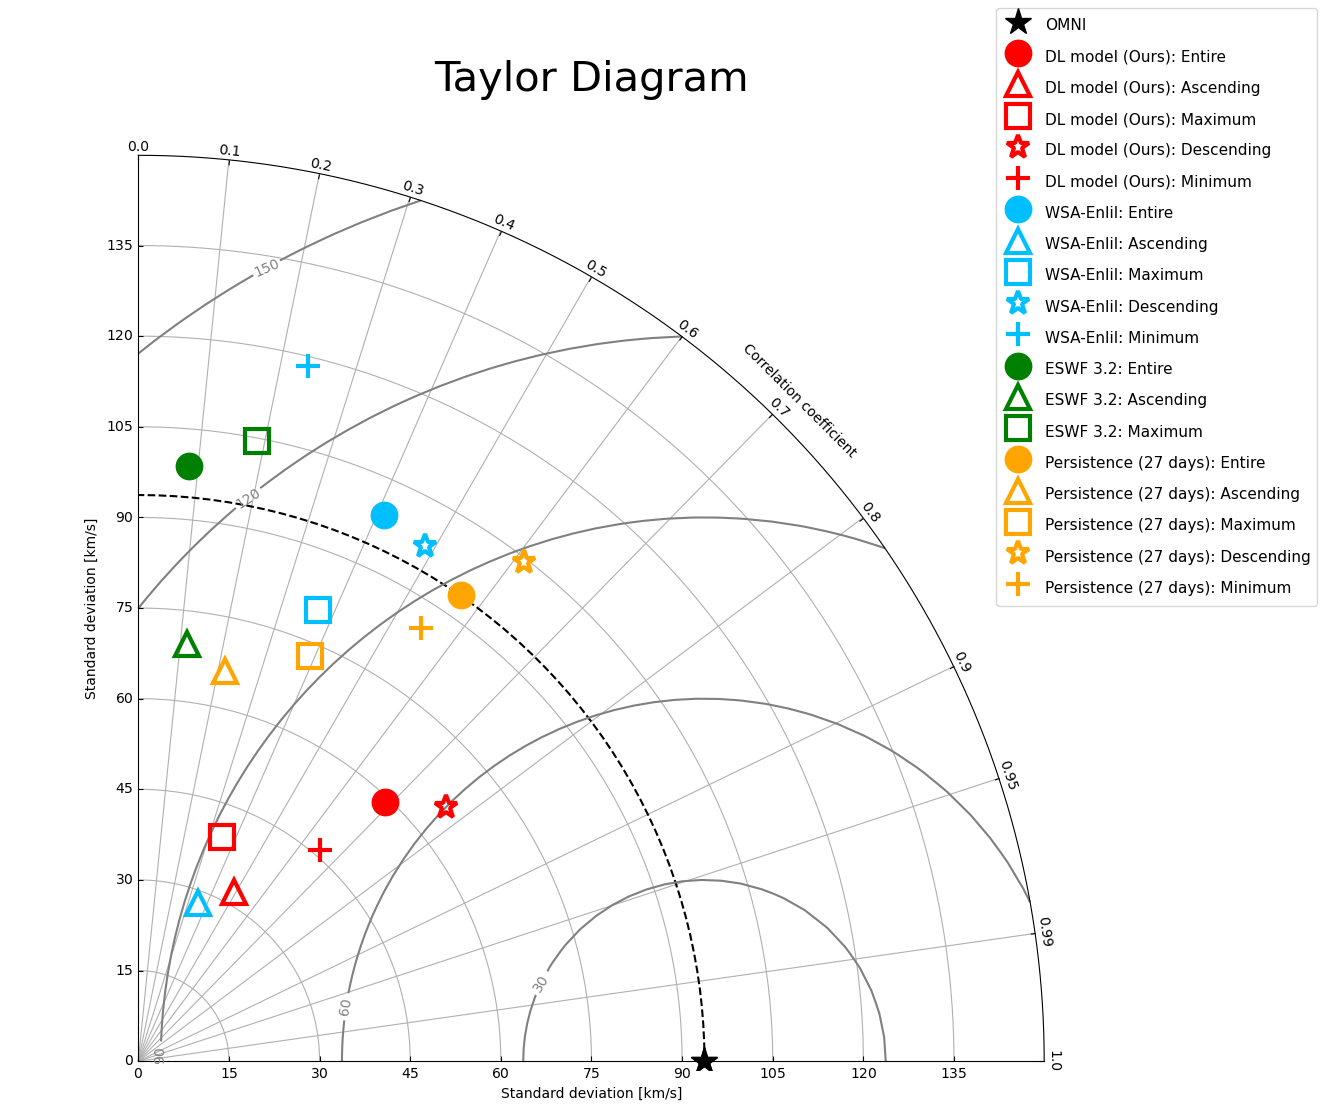

In [10]:
# Taylor Diagram 생성 함수
def create_taylor_diagram():
    # 관측 데이터 (Reference)의 표준편차
    obsSTD = model_taylor_stats['sdev'][0]

    # 모델별 데이터 준비
    datasets = [
        {"stats": model_taylor_stats, "color": "red", "label": "DL model (Ours): Entire", "marker": "o", "fill": True},
        {"stats": model_ascending_taylor_stats, "color": "red", "label": "DL model (Ours): Ascending", "marker": "^"},
        {"stats": model_maximum_taylor_stats, "color": "red", "label": "DL model (Ours): Maximum", "marker": "s"},
        {"stats": model_descending_taylor_stats, "color": "red", "label": "DL model (Ours): Descending", "marker": "*"},
        {"stats": model_minimum_taylor_stats, "color": "red", "label": "DL model (Ours): Minimum", "marker": "+"},

        {"stats": wsa_taylor_stats, "color": "deepskyblue", "label": "WSA-Enlil: Entire", "marker": "o", "fill": True},
        {"stats": wsa_ascending_taylor_stats, "color": "deepskyblue", "label": "WSA-Enlil: Ascending", "marker": "^"},
        {"stats": wsa_maximum_taylor_stats, "color": "deepskyblue", "label": "WSA-Enlil: Maximum", "marker": "s"},
        {"stats": wsa_descending_taylor_stats, "color": "deepskyblue", "label": "WSA-Enlil: Descending", "marker": "*"},
        {"stats": wsa_minimum_taylor_stats, "color": "deepskyblue", "label": "WSA-Enlil: Minimum", "marker": "+"},

        {"stats": eswf_taylor_stats, "color": "green", "label": "ESWF 3.2: Entire", "marker": "o", "fill": True},
        {"stats": eswf_ascending_taylor_stats, "color": "green", "label": "ESWF 3.2: Ascending", "marker": "^"},
        {"stats": eswf_maximum_taylor_stats, "color": "green", "label": "ESWF 3.2: Maximum", "marker": "s"},
        #{"stats": eswf_descending_taylor_stats, "color": "green", "label": "ESWF 3.2: Descending", "marker": "*"},
        #{"stats": eswf_minimum_taylor_stats, "color": "green", "label": "ESWF 3.2: Minimum", "marker": "+"},

        {"stats": persistence_taylor_stats, "color": "orange", "label": "Persistence (27 days): Entire", "marker": "o", "fill": True},
        {"stats": persistence_ascending_taylor_stats, "color": "orange", "label": "Persistence (27 days): Ascending", "marker": "^"},
        {"stats": persistence_maximum_taylor_stats, "color": "orange", "label": "Persistence (27 days): Maximum", "marker": "s"},
        {"stats": persistence_descending_taylor_stats, "color": "orange", "label": "Persistence (27 days): Descending", "marker": "*"},
        {"stats": persistence_minimum_taylor_stats, "color": "orange", "label": "Persistence (27 days): Minimum", "marker": "+"},
    ]

    # Taylor Diagram 생성
    fig = plt.figure(figsize=(15, 12))
    dia = TaylorDiagram(obsSTD, fig=fig, rect=111, label='OMNI')
    #dia = TaylorDiagram(obsSTD, fig=fig, rect=111)

    # Contour 추가
    plt.clabel(dia.add_contours(colors='#808080'), inline=1, fontsize=10)

    # 각 데이터 포인트 추가
    for data in datasets:
        stats = data["stats"]
        color = data["color"]
        label = data["label"]
        marker = data["marker"]
        fill = data.get("fill", False)

        dia.add_sample(
            stats['sdev'][1],  # 표준편차
            stats['ccoef'][1],  # 상관계수
            label=label,
            marker=marker,
            mec=color,
            mfc=color if fill else 'none',  # 전체 기간은 내부 채우기
            mew=3,  # 테두리 두께
            ms=17,  # 마커 크기
        )

    # 범례 추가 (마커 크기 줄이기)
    spl = [p.get_label() for p in dia.samplePoints]
    legend = fig.legend(
        dia.samplePoints,
        spl,
        numpoints=1,
        loc='upper right',  # 오른쪽 상단 위치
        prop=dict(size=11),  # 범례 텍스트 크기
        frameon=True,
        handlelength=2,  # 범례 마커 길이
        handleheight=2,  # 범례 마커 높이
    )

    # 범례에서 선 제거
    for handle in legend.legend_handles:
        handle.set_linewidth(0)

    plt.title("Taylor Diagram", fontsize=30, pad=40)

    # 플롯 조정
    plt.rcParams["figure.figsize"] = [15, 12]  # 플롯 크기를 조금 더 키움
    plt.rcParams['lines.linewidth'] = 4  # 선 두께를 두껍게
    plt.rcParams.update({'font.size': 30})  # 글꼴 크기를 키워 텍스트를 더 잘 보이게

    title_str = "Taylor Diagram with Persistence"
    save_path = "E:\\Research\\SWspeed\\Visualization_2012-2020\\plot_images\\\\{}.png".format(title_str)
    plt.savefig(save_path, dpi=300, bbox_inches='tight')  # Save figure
    
    plt.show()

# Taylor Diagram 생성 및 시각화 실행
create_taylor_diagram()

## Sunspot number vs CC

In [11]:
sunspot_ms_path = "E:/Research/SWspeed/Visualization_2010-2020/sunspot_number/SN_ms_tot_V2.0.txt"
sunspot_m_path = "E:/Research/SWspeed/Visualization_2010-2020/sunspot_number/SN_m_tot_V2.0.txt"

In [12]:
sorted_by_years = {
    '2012': [2128, 2129, 2130, 2131, 2132], 
    '2013': [2141, 2142, 2143, 2144, 2145], 
    '2014': [2155, 2156, 2157, 2158], 
    '2015': [2168, 2169, 2170, 2171, 2172], 
    '2016': [2182, 2183, 2184, 2185], 
    '2017': [2195, 2196, 2197, 2198, 2199], 
    '2018': [2208, 2209, 2210, 2211, 2212], 
    '2019': [2222, 2223, 2224, 2225], 
    '2020': [2235, 2236, 2237, 2238, 2239]
}

model_year_cc_list = []
wsa_year_cc_list = []
eswf_year_cc_list = []
persistence_27days_year_cc_list = []

for year in sorted_by_years:
    omni_dates_oct_dec, omni_speeds_oct_dec = [], []
    model_dates_oct_dec, model_speeds_oct_dec = [], []
    wsa_dates_oct_dec, wsa_speeds_oct_dec = [], []
    eswf_dates_oct_dec, eswf_speeds_oct_dec = [], []
    persistence_27days_dates_oct_dec, persistence_27days_speeds_oct_dec = [], []
    
    for CR in sorted_by_years[year]:
        omni_dates, omni_speeds = OMNI(CR)
        omni_dates_oct_dec.extend(omni_dates)
        omni_speeds_oct_dec.extend(omni_speeds)

        model_dates, model_speeds = DL_Model(CR)
        model_dates_oct_dec.extend(model_dates)
        model_speeds_oct_dec.extend(model_speeds)

        wsa_dates, wsa_speeds = WSA_ENLIL(CR)
        wsa_dates_oct_dec.extend(wsa_dates)
        wsa_speeds_oct_dec.extend(wsa_speeds)

        eswf_dates, eswf_speeds = ESWF3_2(CR)
        eswf_dates_oct_dec.extend(eswf_dates)
        eswf_speeds_oct_dec.extend(eswf_speeds)

        persistence_27days_dates, persistence_27days_speeds = Persistence_27days(CR)
        persistence_27days_dates_oct_dec.extend(persistence_27days_dates)
        persistence_27days_speeds_oct_dec.extend(persistence_27days_speeds)

    omni_dates_oct_dec = np.array(omni_dates_oct_dec)
    model_dates_oct_dec = np.array(model_dates_oct_dec) 
    wsa_dates_oct_dec = np.array(wsa_dates_oct_dec)
    eswf_dates_oct_dec = np.array(eswf_dates_oct_dec)
    persistence_27days_dates_oct_dec = np.array(persistence_27days_dates_oct_dec)

    omni_speeds_oct_dec = np.array(omni_speeds_oct_dec)
    model_speeds_oct_dec = np.array(model_speeds_oct_dec) 
    wsa_speeds_oct_dec = np.array(wsa_speeds_oct_dec)
    eswf_speeds_oct_dec = np.array(eswf_speeds_oct_dec)
    persistence_27days_speeds_oct_dec = np.array(persistence_27days_speeds_oct_dec)

    omni_dates_oct_dec_valid, omni_speeds_oct_dec_valid = [], []
    model_dates_oct_dec_valid, model_speeds_oct_dec_valid = [], []
    wsa_dates_oct_dec_valid, wsa_speeds_oct_dec_valid = [], []
    eswf_dates_oct_dec_valid, eswf_speeds_oct_dec_valid = [], []
    persistence_27days_dates_oct_dec_valid, persistence_27days_speeds_oct_dec_valid = [], []

    valid_index1 = ~np.isnan(omni_speeds_oct_dec) & ~np.isnan(model_speeds_oct_dec) & ~np.isnan(wsa_speeds_oct_dec) & ~np.isnan(eswf_speeds_oct_dec)
    valid_index2 = ~np.isnan(persistence_27days_speeds_oct_dec)
    valid_index = valid_index1 & valid_index2

    omni_dates_oct_dec_valid.extend(omni_dates_oct_dec[valid_index])
    omni_speeds_oct_dec_valid.extend(omni_speeds_oct_dec[valid_index])
    model_dates_oct_dec_valid.extend(model_dates_oct_dec[valid_index])
    model_speeds_oct_dec_valid.extend(model_speeds_oct_dec[valid_index])
    wsa_dates_oct_dec_valid.extend(wsa_dates_oct_dec[valid_index])
    wsa_speeds_oct_dec_valid.extend(wsa_speeds_oct_dec[valid_index])
    eswf_dates_oct_dec_valid.extend(eswf_dates_oct_dec[valid_index])
    eswf_speeds_oct_dec_valid.extend(eswf_speeds_oct_dec[valid_index])
    persistence_27days_dates_oct_dec_valid.extend(persistence_27days_dates_oct_dec[valid_index])
    persistence_27days_speeds_oct_dec_valid.extend(persistence_27days_speeds_oct_dec[valid_index])

    OMNI_valid = []
    model_valid = []
    wsa_valid = []
    eswf_valid = []
    persistence_27days_valid = []
    
    for i in range(len(omni_dates_oct_dec_valid)):
        OMNI_valid.append(omni_speeds_oct_dec_valid[i])
        model_valid.append(model_speeds_oct_dec_valid[i])
        wsa_valid.append(wsa_speeds_oct_dec_valid[i])
        eswf_valid.append(eswf_speeds_oct_dec_valid[i])
        persistence_27days_valid.append(persistence_27days_speeds_oct_dec_valid[i])

    model_pcc, _ = pearsonr(OMNI_valid, model_valid)
    wsa_pcc, _ = pearsonr(OMNI_valid, wsa_valid)
    eswf_pcc, _ = pearsonr(OMNI_valid, eswf_valid)
    persistence_27days_pcc, _ = pearsonr(OMNI_valid, persistence_27days_valid)

    model_year_cc_list.append(model_pcc)
    wsa_year_cc_list.append(wsa_pcc)
    eswf_year_cc_list.append(eswf_pcc)
    persistence_27days_year_cc_list.append(persistence_27days_pcc)

    print(np.round(model_pcc, 3))
    print(np.round(wsa_pcc, 3))
    print(np.round(eswf_pcc, 3))
    print(np.round(persistence_27days_pcc, 3), '\n')

0.491
0.352
0.117
0.217 

0.348
0.182
-0.01
0.249 

0.443
0.229
0.023
0.366 

0.756
0.454
0.273
0.446 

0.862
0.687
-0.154
0.749 

0.763
0.386
-0.187
0.644 

0.709
0.335
-0.125
0.569 

0.702
0.277
0.094
0.673 

0.655
0.245
-0.208
0.472 



In [13]:
model_month_cc_list = []
wsa_month_cc_list = []
eswf_month_cc_list = []
persistence_27days_month_cc_list = []

for i in range(len(model_year_cc_list)):
    for j in range(0, 12):
        if j != 10:
            model_month_cc_list.append(np.nan)
            wsa_month_cc_list.append(np.nan)
            eswf_month_cc_list.append(np.nan)
            persistence_27days_month_cc_list.append(np.nan)
        else:
            model_month_cc_list.append(model_year_cc_list[i])
            wsa_month_cc_list.append(wsa_year_cc_list[i])
            eswf_month_cc_list.append(eswf_year_cc_list[i])
            persistence_27days_month_cc_list.append(persistence_27days_year_cc_list[i])

In [14]:
series = pd.Series(model_month_cc_list)
model_month_cc_list = series.interpolate(method='linear', limit_direction='both')
model_month_cc_list = model_month_cc_list.tolist()

series = pd.Series(wsa_month_cc_list)
wsa_month_cc_list = series.interpolate(method='linear', limit_direction='both')
wsa_month_cc_list = wsa_month_cc_list.tolist()

series = pd.Series(eswf_month_cc_list)
eswf_month_cc_list = series.interpolate(method='linear', limit_direction='both')
eswf_month_cc_list = eswf_month_cc_list.tolist()

series = pd.Series(persistence_27days_month_cc_list)
persistence_27days_month_cc_list = series.interpolate(method='linear', limit_direction='both')
persistence_27days_month_cc_list = persistence_27days_month_cc_list.tolist()

In [15]:
date = []
sunspot_num_m = []
sunspot_num_ms = []

with open(sunspot_m_path, 'r') as f:
    for line in f.readlines():
        date.append(datetime.strptime(line[:7], '%Y %m'))
        sunspot_num_m.append(float(line[18:23]))

with open(sunspot_ms_path, 'r') as f:
    for line in f.readlines():
        sunspot_num_ms.append(float(line[18:23]))

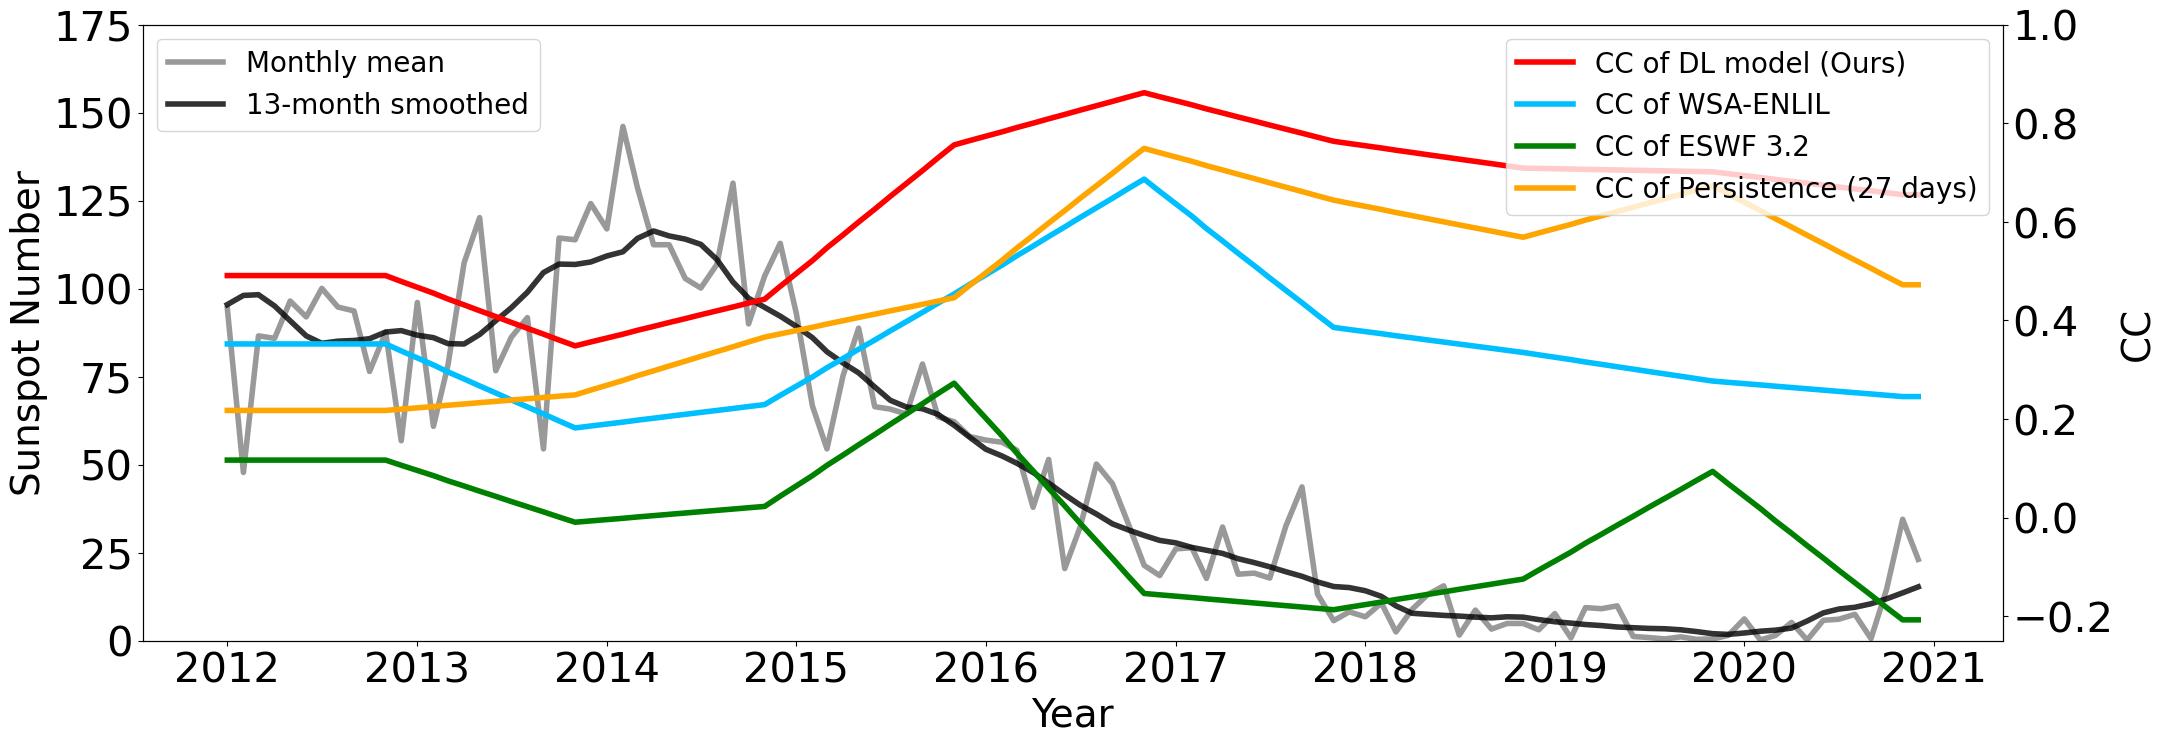

In [16]:
fig, ax1 = plt.subplots(figsize=(24, 8))

ax1.plot(date, sunspot_num_m, c='gray', alpha=0.8, label='Monthly mean')
ax1.plot(date, sunspot_num_ms, c='black', alpha=0.8, label='13-month smoothed')
ax1.set_xlabel("Year", fontsize=28)
ax1.set_ylabel("Sunspot Number", fontsize=28)
ax1.set_ylim(0, 175)
ax1.legend(loc='upper left', fontsize=20)

ax2 = ax1.twinx()
ax2.plot(date, model_month_cc_list, c='red', label='CC of DL model (Ours)')
ax2.plot(date, wsa_month_cc_list, c='deepskyblue', label='CC of WSA-ENLIL')
ax2.plot(date, eswf_month_cc_list, c='green', label='CC of ESWF 3.2')
ax2.plot(date, persistence_27days_month_cc_list, c='orange', label='CC of Persistence (27 days)')
ax2.set_ylabel("CC", fontsize=28)
ax2.set_ylim(-0.25, 1)
ax2.legend(loc='upper right', fontsize=20)

title_str = "Sunspot Number vs CC (models)"
save_path = "E:\\Research\\SWspeed\\Visualization_2012-2020\\plot_images\\\\{}.png".format(title_str)
plt.savefig(save_path, dpi=300, bbox_inches='tight')  # Save figure

plt.show()

---

## Event-based verification

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

import requests
from bs4 import BeautifulSoup
from io import StringIO

from data.omni import OMNI
from data.wsa_enlil import WSA_ENLIL
from data.eswf3_2 import ESWF3_2
from data.dl_model import DL_Model

CR_df = (
    pd.read_csv('E:/Research/SWspeed/Carrington_Rotation_Data__Oct-Dec__2010-2020_.csv')
      .assign(
          Start=lambda df: pd.to_datetime(df['Start Date']),
          End  =lambda df: pd.to_datetime(df['End Date'])
      )
)

In [18]:
def CR_listing(cr):
    CR_df['Start Date'] = pd.to_datetime(CR_df['Start Date'])
    CR_df['End Date']   = pd.to_datetime(CR_df['End Date'])
    
    row = CR_df.loc[CR_df['Carrington Rotation Number'] == cr].iloc[0]
    
    times = pd.date_range(row['Start Date'], row['End Date'], freq='1h')
    selected = times[times.hour % 6 == 0]
    
    return selected.strftime('%Y-%m-%d %H:00').tolist()

In [19]:
def POD(TP, FP, FN):
    return TP / (TP + FN)

def FNR(TP, FP, FN):
    return FN / (TP + FN)

def PPV(TP, FP, FN):
    return TP / (TP + FP)

def FAR(TP, FP, FN):
    return FP / (TP + FP)

def TS(TP, FP, FN):
    return TP / (TP + FP + FN)

def BS(TP, FP, FN):
    return (TP + FP) / (TP + FN)

def event_verification(TP, FP, FN):
    return np.round(POD(TP, FP, FN), 2), np.round(FNR(TP, FP, FN), 2), \
            np.round(PPV(TP, FP, FN), 2), np.round(FAR(TP, FP, FN), 2), \
            np.round(TS(TP, FP, FN), 2), np.round(BS(TP, FP, FN), 2)

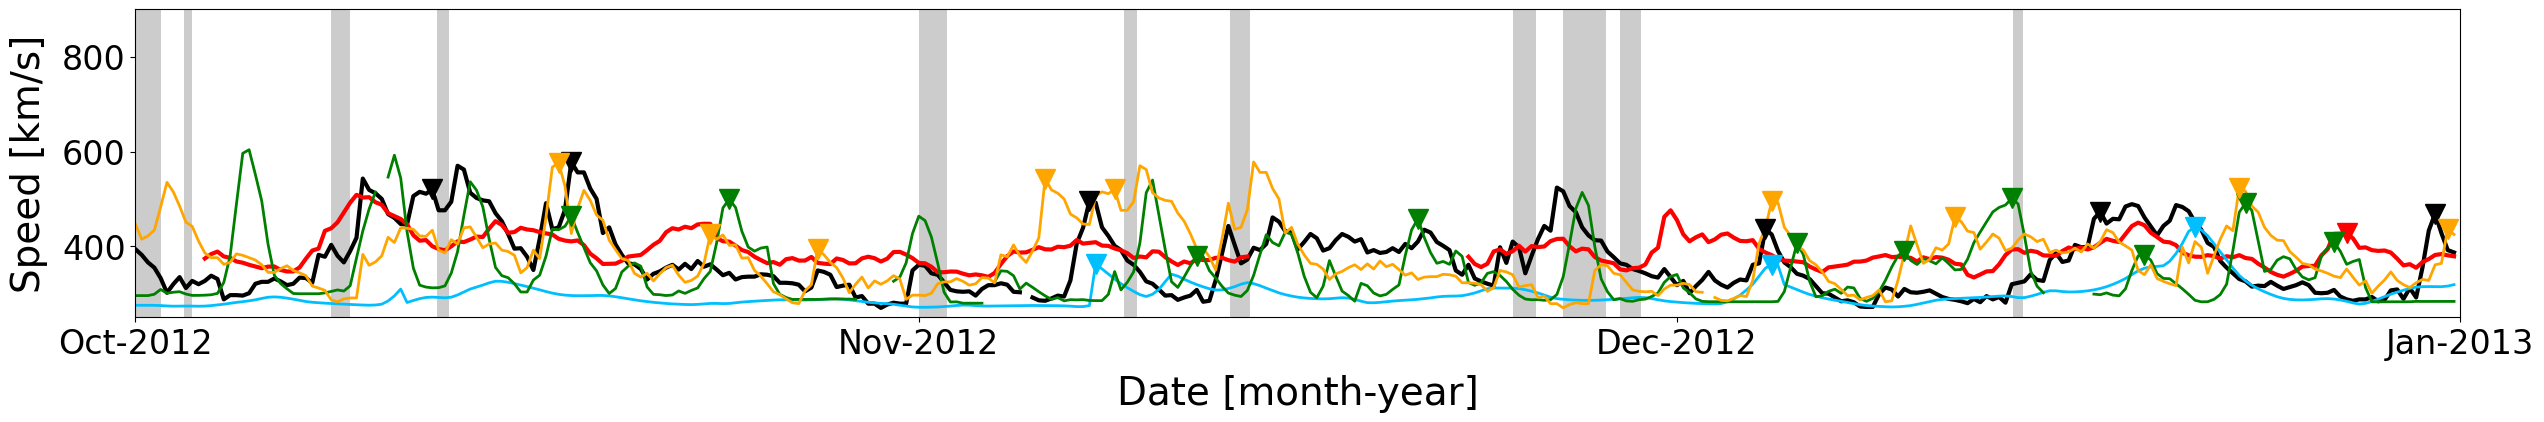

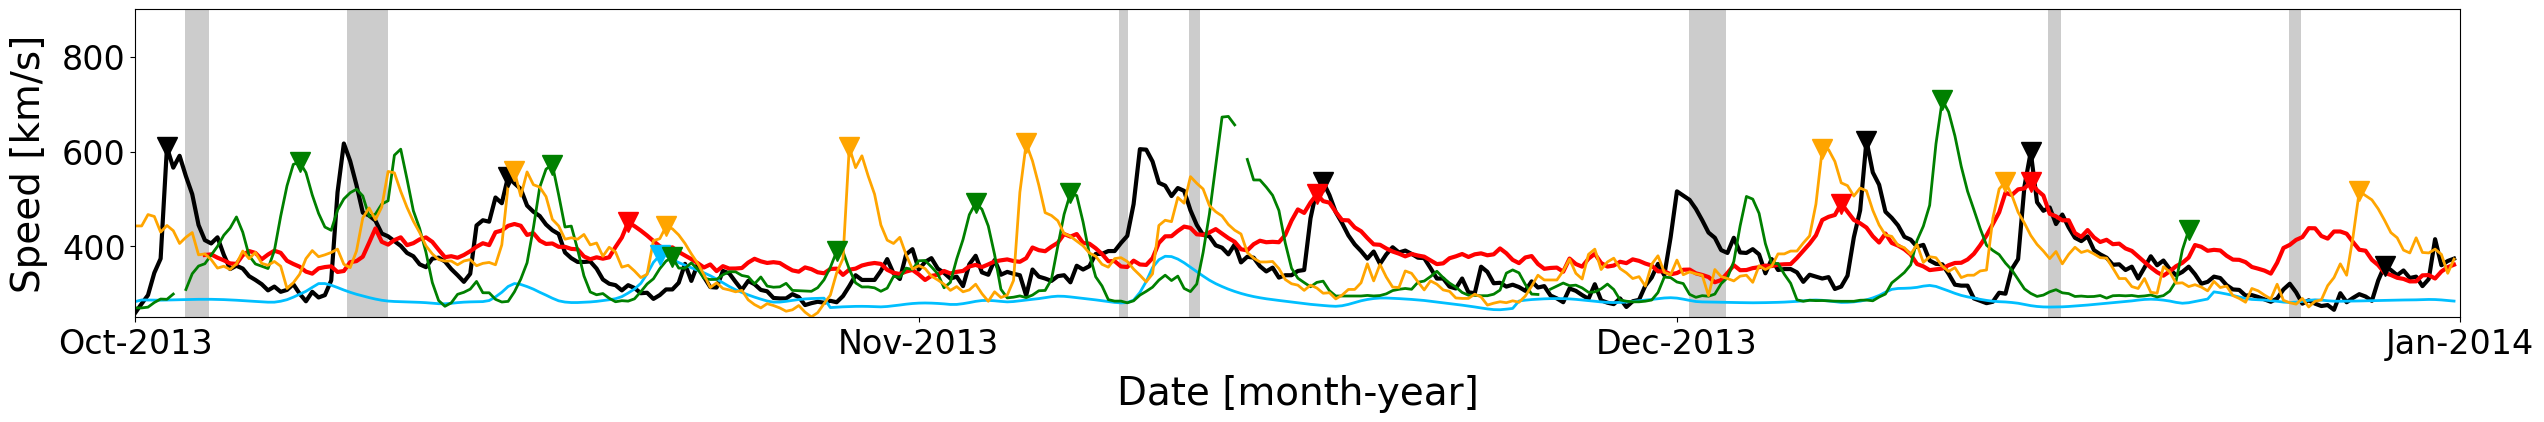

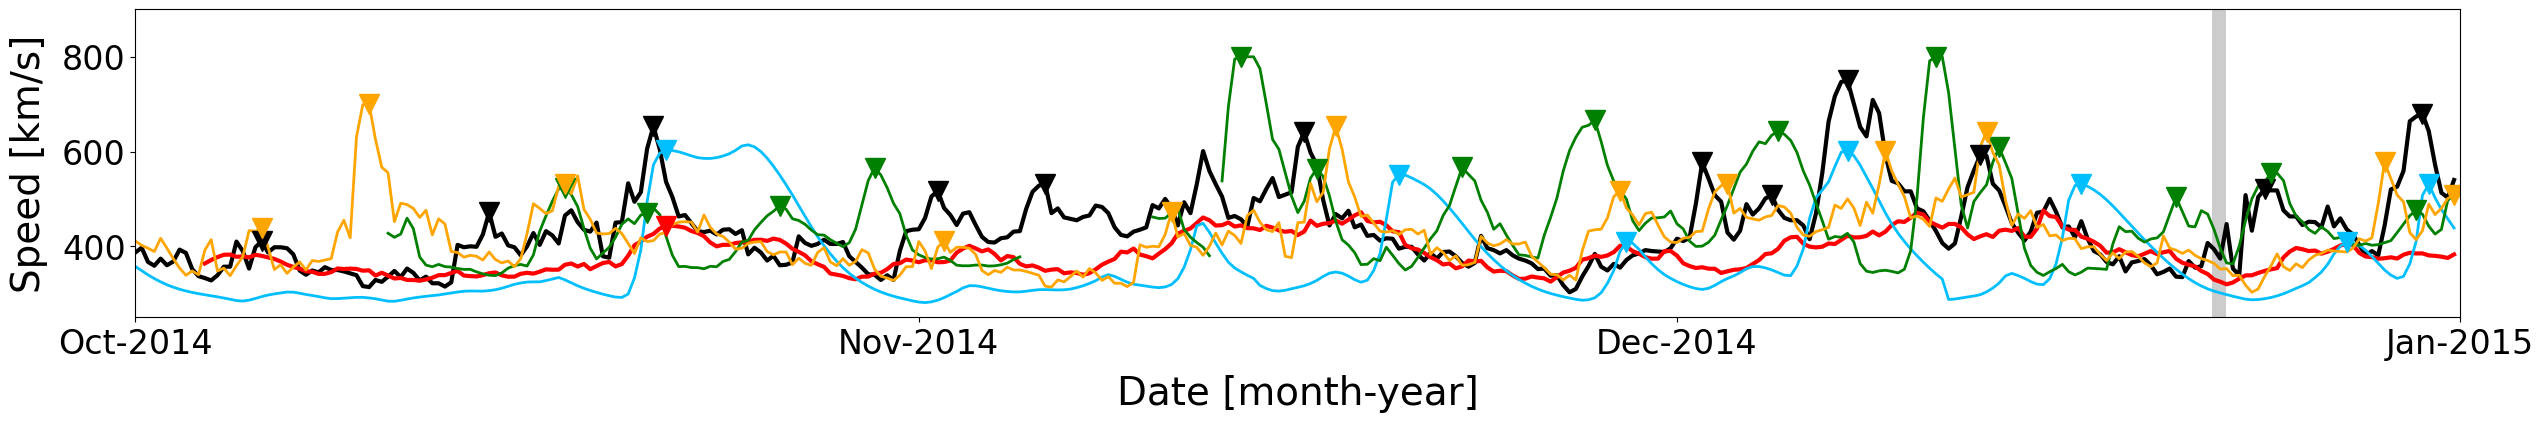

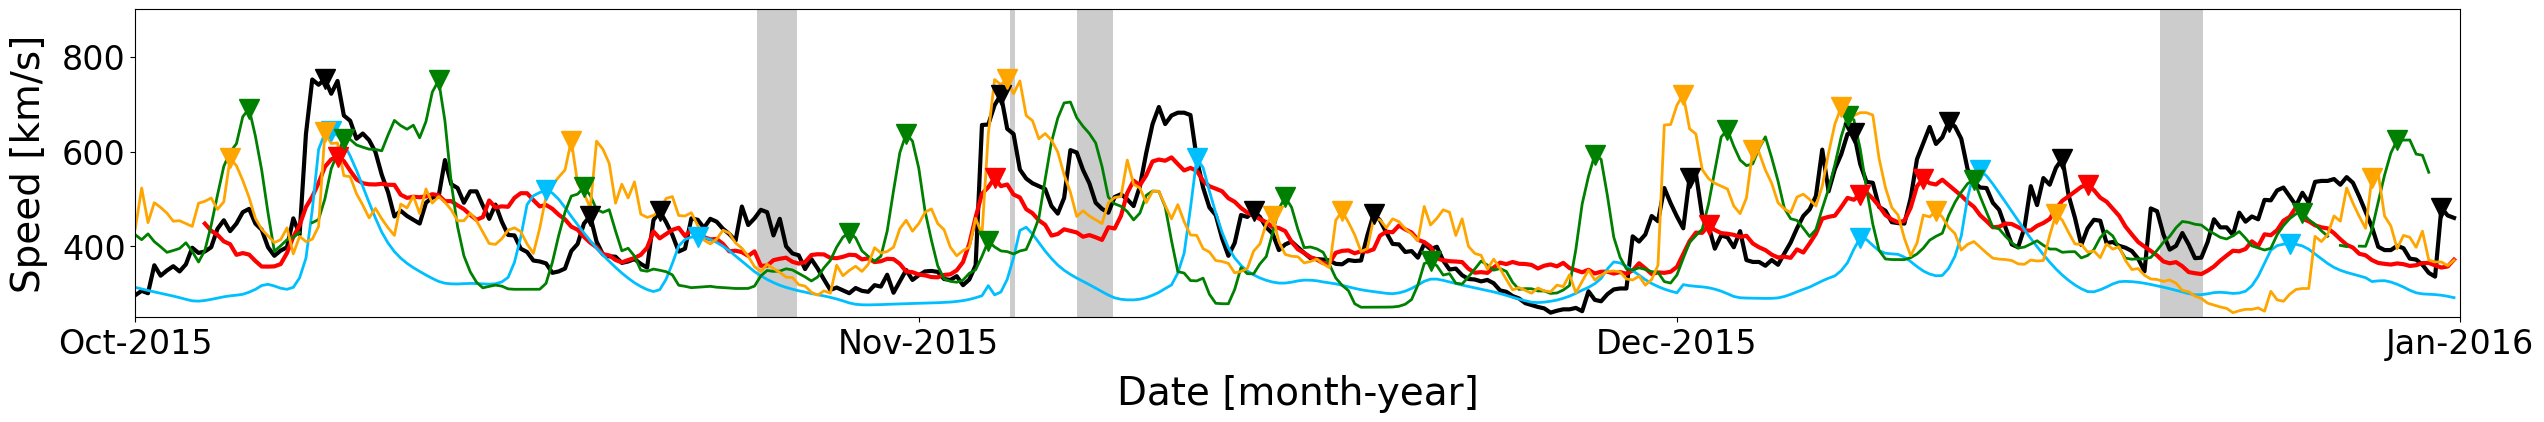

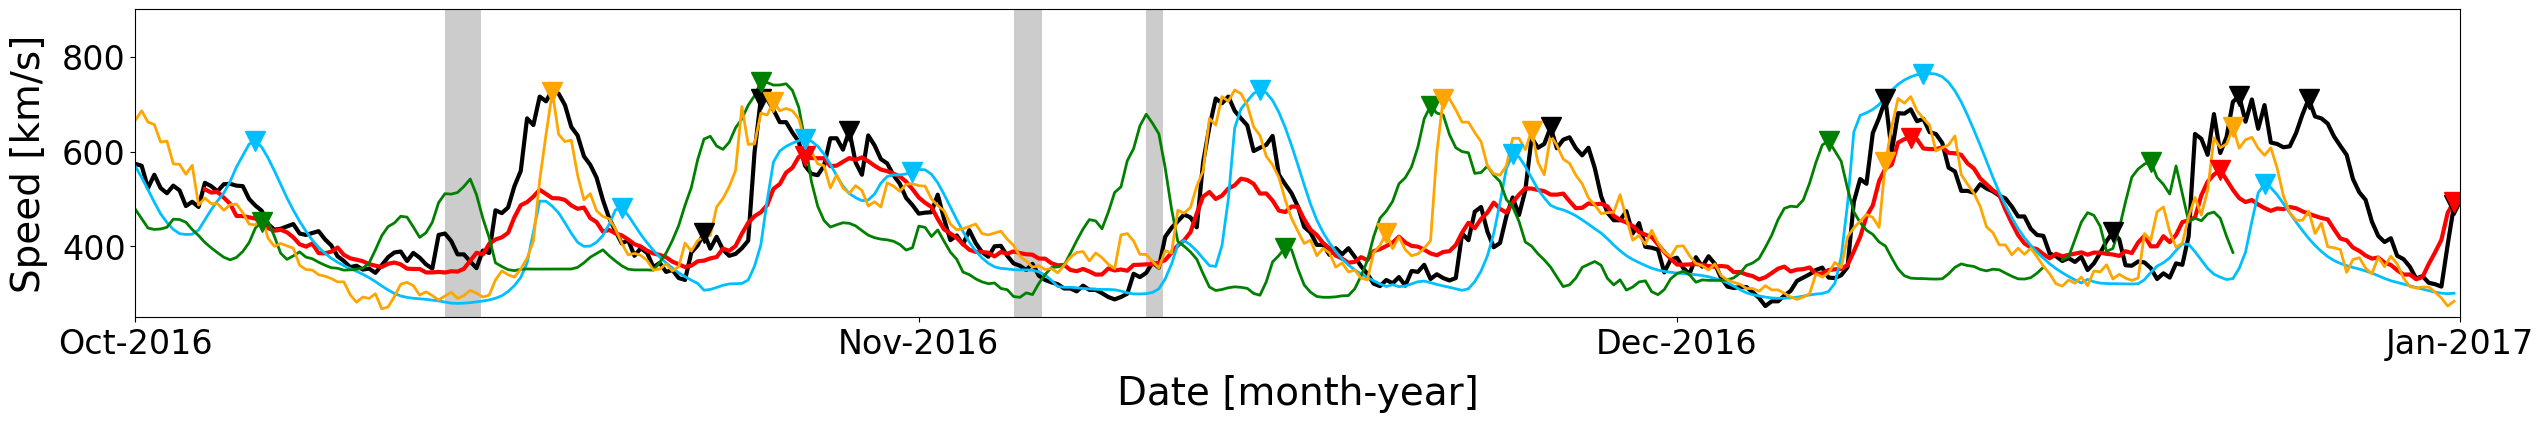

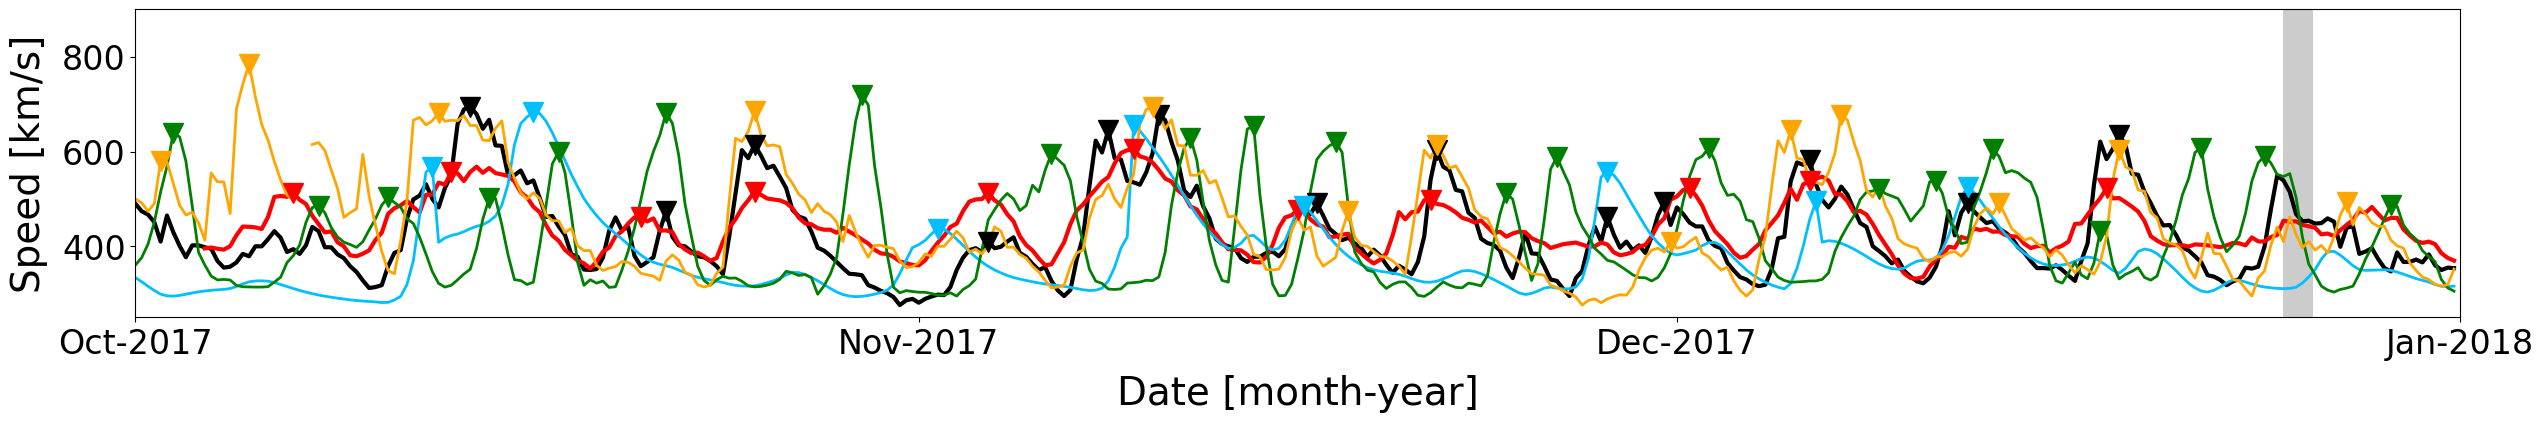

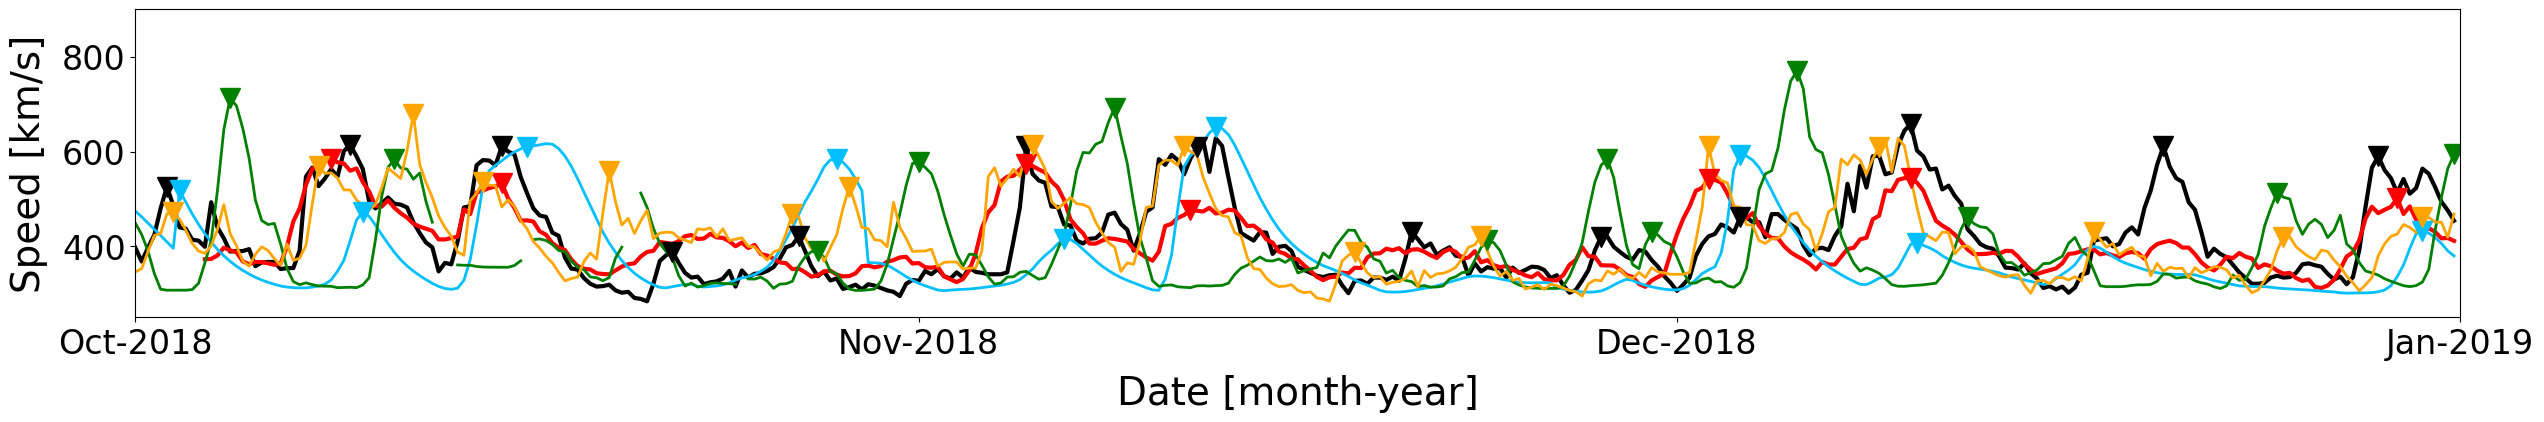

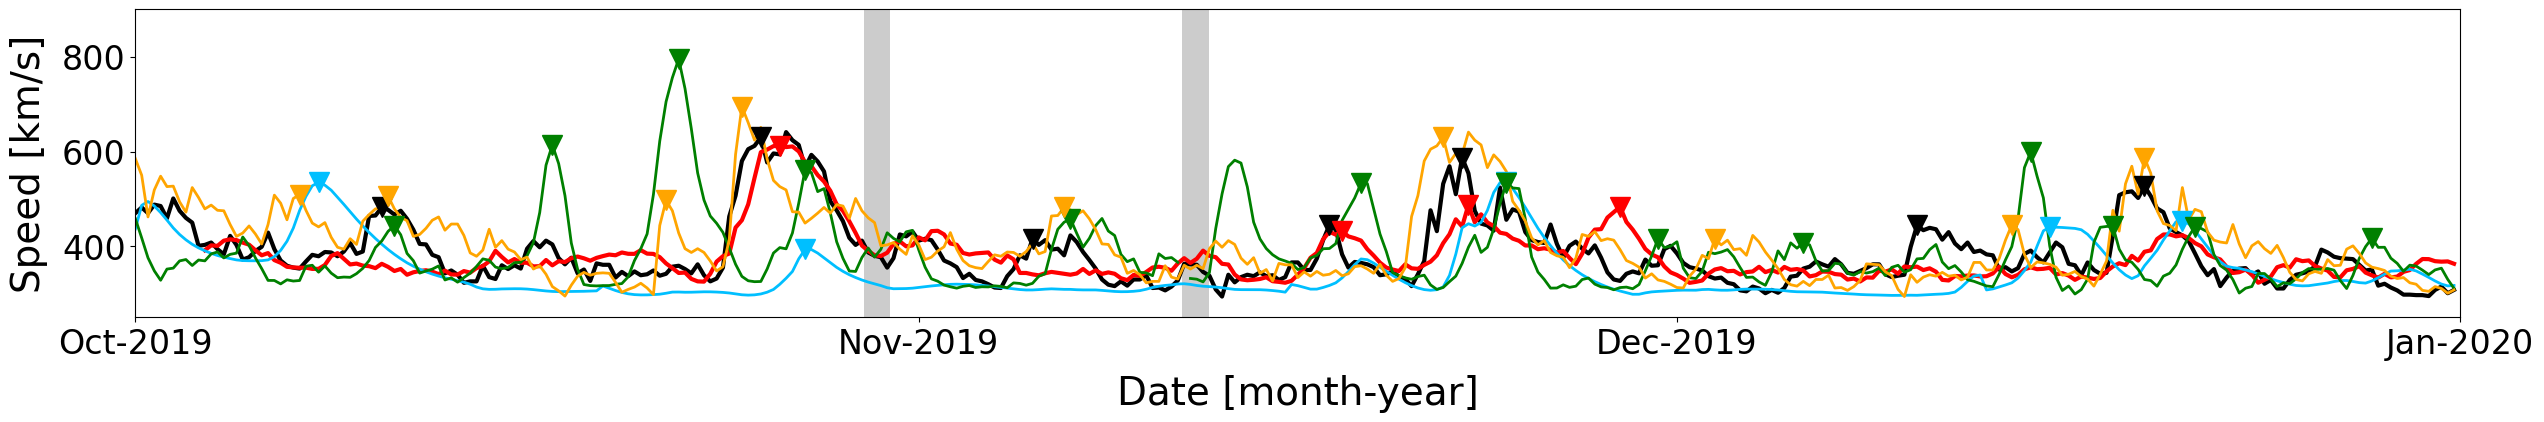

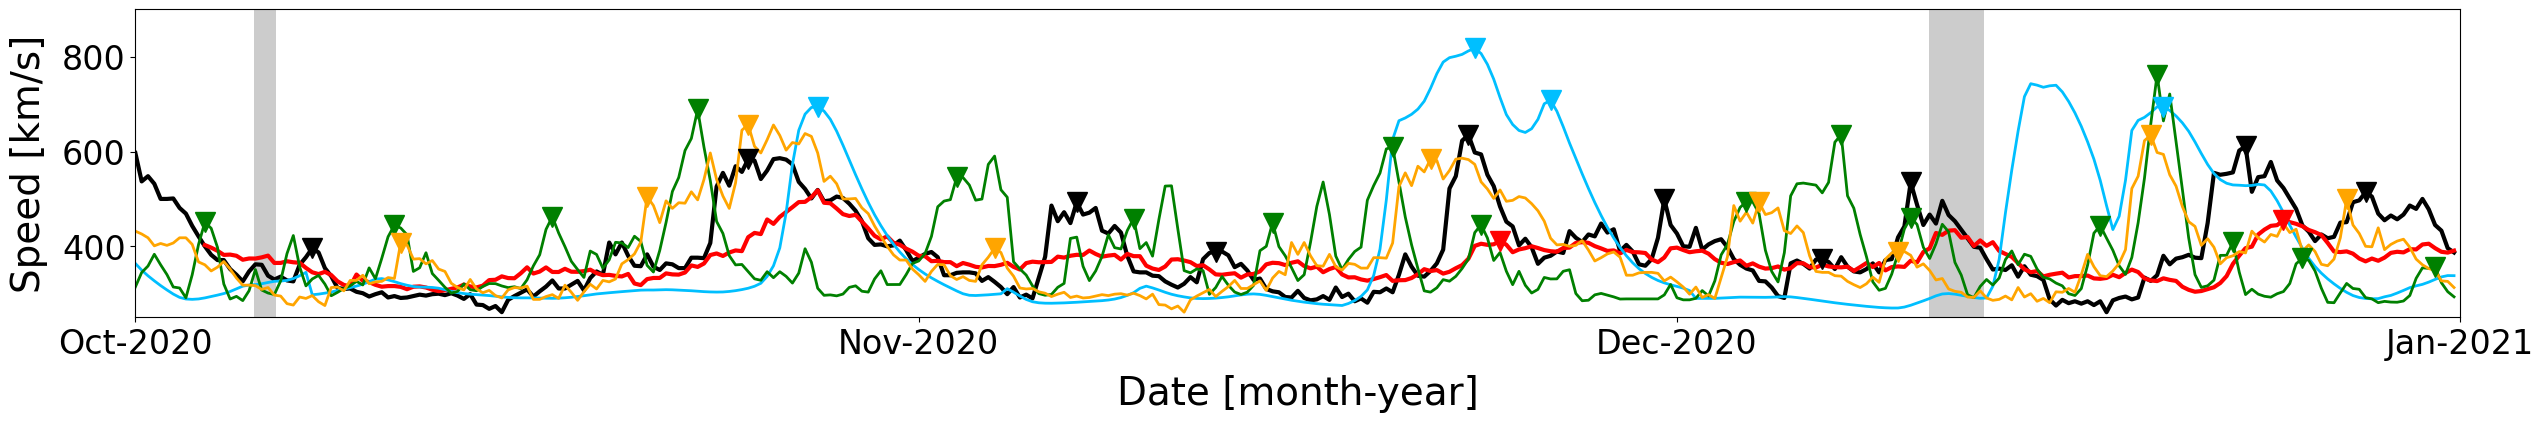

In [20]:
sorted_by_years = {
    '2012': [2128, 2129, 2130, 2131, 2132], 
    '2013': [2141, 2142, 2143, 2144, 2145], 
    '2014': [2155, 2156, 2157, 2158], 
    '2015': [2168, 2169, 2170, 2171, 2172], 
    '2016': [2182, 2183, 2184, 2185], 
    '2017': [2195, 2196, 2197, 2198, 2199], 
    '2018': [2208, 2209, 2210, 2211, 2212], 
    '2019': [2222, 2223, 2224, 2225], 
    '2020': [2235, 2236, 2237, 2238, 2239]
}

omni_peaks_list = []
model_peaks_list = []
wsa_peaks_list = []
eswf_peaks_list = []
persistence_peaks_list = []

for year in sorted_by_years:

    CR_list = sorted_by_years[year]
    time_list = []
    
    omni_dates_list, omni_speeds_list = [], []
    model_dates_list, model_speeds_list = [], []
    wsa_dates_list, wsa_speeds_list = [], []
    eswf3_2dates_list, eswf3_2speeds_list = [], []
    persistence_dates_list, persistence_speeds_list = [], []
    
    icme_events = []
    for CR in CR_list:
        time_crlist = [time for time in (datetime.strptime(time_str, '%Y-%m-%d %H:%M') for time_str in CR_listing(CR)) if time.month <= 12]
        time_list.extend(time_crlist)
        
        rotation_period = CR_df[CR_df['Carrington Rotation Number'] == CR]
        start_date = pd.to_datetime(rotation_period.iloc[0]['Start Date'])
        end_date = pd.to_datetime(rotation_period.iloc[0]['End Date'])
        
        for icme in icme_event_list:
            icme_start, icme_end = icme
            icme_start = datetime.strptime(icme_start, '%Y-%m-%d %H:%M')
            icme_end = datetime.strptime(icme_end, '%Y-%m-%d %H:%M')
            
            if start_date <= icme_start <= end_date and start_date <= icme_end <= end_date:
                icme_events.append([icme_start, icme_end])
        
        # Model data
        omni_dates, omni_speeds = OMNI(CR)
        model_dates, model_speeds = DL_Model(CR)
        wsa_dates, wsa_speeds = WSA_ENLIL(CR)
        eswf3_2dates, eswf3_2speeds = ESWF3_2(CR)
        persistence_dates, persistence_speeds = Persistence_27days(CR)
    
        omni_dates_list.extend(omni_dates)
        omni_speeds_list.extend(omni_speeds)
            
        model_dates_list.extend(model_dates)
        model_speeds_list.extend(model_speeds)
    
        wsa_dates_list.extend(wsa_dates)
        wsa_speeds_list.extend(wsa_speeds)
    
        eswf3_2dates_list.extend(eswf3_2dates)
        eswf3_2speeds_list.extend(eswf3_2speeds)

        persistence_dates_list.extend(persistence_dates)
        persistence_speeds_list.extend(persistence_speeds)
    
    plt.figure(figsize = (30, 4))
        
    # Model
    plt.plot(time_list, omni_speeds_list, c='black', label='OMNI', linewidth=3)  # OMNI
    plt.plot(time_list, model_speeds_list, c='r', label='DL model', linewidth=3)  # DL Model
    plt.plot(time_list, wsa_speeds_list, c='deepskyblue', label='WSA-Enlil', linewidth=2)  # WSA-Enlil model
    plt.plot(time_list, eswf3_2speeds_list, c='g', label='ESWF3.2', linewidth=2)  # ESWF3.2 model
    plt.plot(time_list, persistence_speeds_list, c='orange', label='Persistence (27 days)', linewidth=2)  # Persistence model
    
    # ICME event (gray shading)
    if len(icme_events) > 0:
        for icme_event in icme_events:
            icme_start, icme_end = icme_event
            plt.axvspan(icme_start, icme_end, facecolor='gray', alpha=0.4)

    #plt.title("Model Comparisons of SIR in {}".format(year), fontsize = 20)
    
    xiim_list = [time_obj for time_obj in time_list if time_obj.month in [10, 11, 12]]
    plt.xlim(xiim_list[0], xiim_list[-1])
    plt.ylim(250, 900)
    
    
    
    ########################################################################
    
    omni_event_points_dict = {'dates': [], 'speeds': [], 'index': []}
    for i in range(4, len(omni_dates_list) - 1):
        if omni_speeds_list[i] > omni_speeds_list[i - 4] + 50 and not any(isinstance(x, float) and np.isnan(x) for x in omni_dates_list[i-4:i+1]):
            omni_event_points_dict['dates'].append(omni_dates_list[i-4:i+1])
            omni_event_points_dict['speeds'].append(omni_speeds_list[i-4:i+1])
            omni_event_points_dict['index'].append(i)
    
    elim_date_points, elim_speed_points, elim_index_points = [], [], []
    for p, (current, next_) in enumerate(zip(omni_event_points_dict['dates'][:-1], omni_event_points_dict['dates'][1:])):
        if current[1] == next_[0]:
            elim_date_points.append(current)
            elim_speed_points.append(omni_event_points_dict['speeds'][p])
            elim_index_points.append(omni_event_points_dict['index'][p])
    
    omni_event_groups_dict = {'dates': [], 'speeds': [], 'index': []}
    current_group = [elim_index_points[0]]
    for i in range(1, len(elim_index_points)):
        if elim_index_points[i] == elim_index_points[i - 1] + 1:
            current_group.append(elim_index_points[i])
        else:
            omni_event_groups_dict['index'].append(current_group)
            current_group = [elim_index_points[i]]
    
    # 마지막 그룹도 리스트에 추가
    if current_group:
        omni_event_groups_dict['index'].append(current_group)
    
    for i_list in omni_event_groups_dict['index']:
        omni_event_groups_dict['dates'].append([time_list[i] for i in i_list])
        omni_event_groups_dict['speeds'].append([omni_speeds_list[i] for i in i_list])
    
    # SIR v_min, v_max 찾기
    SIR_dict = {'dates': [], 'speeds': [], 'index': []}
    for i_list in omni_event_groups_dict['index']:
        HSE_start, HSE_end = i_list[0], i_list[-1]
        # Find v_min
        v_min_segment = omni_speeds_list[HSE_start-8:HSE_start+1]
        argmin_index = np.argmin(v_min_segment)
        min_date = time_list[HSE_start-8 + argmin_index]
        min_speed = v_min_segment[argmin_index]
        min_index = HSE_start-8 + argmin_index
    
        # Find v_max
        v_max_segment = omni_speeds_list[HSE_end:HSE_end+5]
        argmax_index = np.argmax(v_max_segment)
        max_date = time_list[HSE_end + argmax_index]
        max_speed = v_max_segment[argmax_index]
        max_index = HSE_end + argmax_index
    
        # Append results to SIR_dict
        SIR_dict['dates'].append([min_date, max_date])
        SIR_dict['speeds'].append([min_speed, max_speed])
        SIR_dict['index'].append([min_index, max_index])
    
        #plt.plot(time_list[max_index], omni_speeds_list[max_index], color='black', marker='v', markersize=7)  
    
    merged_SIR_dict = {'dates': [], 'speeds': [], 'index': []}
    current_start, current_end = SIR_dict['dates'][0]
    current_speeds = [SIR_dict['speeds'][0]]
    current_indices = [SIR_dict['index'][0]]
    
    for i in range(1, len(SIR_dict['dates'])):
        next_start, next_end = SIR_dict['dates'][i]
        next_speed = SIR_dict['speeds'][i]
        next_index = SIR_dict['index'][i]
        
        if next_start - current_end <= timedelta(hours=18):
            current_end = next_end
            current_speeds.append(next_speed)
            current_indices.append(next_index)
        else:
            merged_SIR_dict['dates'].append([current_start, current_end])
            merged_SIR_dict['speeds'].append(current_speeds)
            merged_SIR_dict['index'].append(current_indices)
            current_start, current_end = next_start, next_end
            current_speeds = [next_speed]
            current_indices = [next_index]
    
    # Append the last interval
    merged_SIR_dict['dates'].append([current_start, current_end])
    merged_SIR_dict['speeds'].append(current_speeds)
    merged_SIR_dict['index'].append(current_indices)
    
    merged_SIR_speed_list = []
    for sir in merged_SIR_dict['speeds']:
        if len(sir) > 1:
            merged_SIR_speed_list.append([sir[0][0], sir[1][1]])
        else: 
            merged_SIR_speed_list.append(sir[0])
    merged_SIR_dict['speeds'] = merged_SIR_speed_list
    
    merged_SIR_index_list = []
    for sir in merged_SIR_dict['index']:
        if len(sir) > 1:
            merged_SIR_index_list.append([sir[0][0], sir[1][1]])
        else: 
            merged_SIR_index_list.append(sir[0])
    merged_SIR_dict['index'] = merged_SIR_index_list
    
    merged2_SIR_dict = {'dates': [], 'speeds': [], 'index': []}
    for e in range(len(merged_SIR_dict['index'])):
        SIR_index = merged_SIR_dict['index'][e]
        if SIR_index[1] - SIR_index[0] > 2:
            merged2_SIR_dict['dates'].append(merged_SIR_dict['dates'][e])
            merged2_SIR_dict['speeds'].append(merged_SIR_dict['speeds'][e])
            merged2_SIR_dict['index'].append(merged_SIR_dict['index'][e])
    
    regrouped_SIR_dict = {'dates': [], 'speeds': [], 'index': []}
    for i in range(len(merged2_SIR_dict['index'])):
        SIR_start, SIR_end = merged2_SIR_dict['index'][i]
        SIR_speeds_list = omni_speeds_list[SIR_start: SIR_end+1]
        max_index = SIR_start + np.nanargmax(SIR_speeds_list)
        v_min, v_max = np.min(SIR_speeds_list), np.max(SIR_speeds_list)
        if v_min >= 500 and v_max <= 400 and v_max-v_min < 100:
            continue
        else:
            regrouped_SIR_dict['dates'].append(merged2_SIR_dict['dates'][i])
            regrouped_SIR_dict['speeds'].append(merged2_SIR_dict['speeds'][i])
            regrouped_SIR_dict['index'].append(merged2_SIR_dict['index'][i])
            #plt.plot(time_list[max_index], omni_speeds_list[max_index], color='black', marker='v', markersize=7)
    
    # icme_event_list의 날짜를 datetime 형식으로 변환
    icme_list = [
        [datetime.strptime(event[0], "%Y-%m-%d %H:%M"), datetime.strptime(event[1], "%Y-%m-%d %H:%M")]
        for event in icme_event_list
    ]
    
    # 겹치는 기간이 있는지 확인하는 함수
    def is_overlapping(event1, event2):
        return event1[0] <= event2[1] and event2[0] <= event1[1]
    
    # icme와 겹치지 않는 이벤트 필터링
    filtered_dates = []
    filtered_speeds = []
    filtered_index = []
    
    for i, sir_event in enumerate(regrouped_SIR_dict['dates']):
        overlap = False
        for icme_event in icme_list:
            if is_overlapping(sir_event, icme_event):
                overlap = True
                break
        if not overlap:
            filtered_dates.append(sir_event)
            filtered_speeds.append(regrouped_SIR_dict['speeds'][i])
            filtered_index.append(regrouped_SIR_dict['index'][i])
    
    # 결과 저장
    filtered_SIR_dict = {
        'dates': filtered_dates,
        'speeds': filtered_speeds,
        'index': filtered_index
    }
    
    for i in range(len(filtered_SIR_dict['index'])):
        SIR_start, SIR_end = filtered_SIR_dict['index'][i]
        SIR_speeds_list = omni_speeds_list[SIR_start: SIR_end+1]
        max_index = SIR_start + np.nanargmax(SIR_speeds_list)
        v_min, v_max = np.min(SIR_speeds_list), np.max(SIR_speeds_list)
        if v_min >= 500 and v_max <= 400 and v_max-v_min < 100:
            continue
        else:
            plt.plot(time_list[max_index], omni_speeds_list[max_index], color='black', marker='v', markersize=14)
            omni_peaks_list.append(time_list[max_index])
            # peak 기준 2일
            #plt.axvspan(time_list[max_index-8], time_list[max_index+9], facecolor='yellow', alpha=0.4)
    
    # Plotting
    #for SIR_start, SIR_end in filtered_SIR_dict['dates']:
    #    plt.axvspan(SIR_start, SIR_end, facecolor='yellow', alpha=0.4)
        
    ########################################################################
    
    model_event_points_dict = {'dates': [], 'speeds': [], 'index': []}
    for i in range(4, len(model_dates_list) - 1):
        if model_speeds_list[i] > model_speeds_list[i - 4] + 50 and not any(isinstance(x, float) and np.isnan(x) for x in model_dates_list[i-4:i+1]):
            model_event_points_dict['dates'].append(model_dates_list[i-4:i+1])
            model_event_points_dict['speeds'].append(model_speeds_list[i-4:i+1])
            model_event_points_dict['index'].append(i)
    
    elim_date_points, elim_speed_points, elim_index_points = [], [], []
    for p, (current, next_) in enumerate(zip(model_event_points_dict['dates'][:-1], model_event_points_dict['dates'][1:])):
        if current[1] == next_[0]:
            elim_date_points.append(current)
            elim_speed_points.append(model_event_points_dict['speeds'][p])
            elim_index_points.append(model_event_points_dict['index'][p])
    
    model_event_groups_dict = {'dates': [], 'speeds': [], 'index': []}
    current_group = [elim_index_points[0]]
    for i in range(1, len(elim_index_points)):
        if elim_index_points[i] == elim_index_points[i - 1] + 1:
            current_group.append(elim_index_points[i])
        else:
            model_event_groups_dict['index'].append(current_group)
            current_group = [elim_index_points[i]]
    
    # 마지막 그룹도 리스트에 추가
    if current_group:
        model_event_groups_dict['index'].append(current_group)
    
    for i_list in model_event_groups_dict['index']:
        model_event_groups_dict['dates'].append([time_list[i] for i in i_list])
        model_event_groups_dict['speeds'].append([model_speeds_list[i] for i in i_list])
    
    # SIR v_min, v_max 찾기
    SIR_dict = {'dates': [], 'speeds': [], 'index': []}
    for i_list in model_event_groups_dict['index']:
        HSE_start, HSE_end = i_list[0], i_list[-1]
        # Find v_min
        v_min_segment = model_speeds_list[HSE_start-8:HSE_start+1]
        argmin_index = np.argmin(v_min_segment)
        min_date = time_list[HSE_start-8 + argmin_index]
        min_speed = v_min_segment[argmin_index]
        min_index = HSE_start-8 + argmin_index
    
        # Find v_max
        v_max_segment = model_speeds_list[HSE_end:HSE_end+5]
        argmax_index = np.argmax(v_max_segment)
        max_date = time_list[HSE_end + argmax_index]
        max_speed = v_max_segment[argmax_index]
        max_index = HSE_end + argmax_index
    
        # Append results to SIR_dict
        SIR_dict['dates'].append([min_date, max_date])
        SIR_dict['speeds'].append([min_speed, max_speed])
        SIR_dict['index'].append([min_index, max_index])
    
    merged_SIR_dict = {'dates': [], 'speeds': [], 'index': []}
    current_start, current_end = SIR_dict['dates'][0]
    current_speeds = [SIR_dict['speeds'][0]]
    current_indices = [SIR_dict['index'][0]]
    
    for i in range(1, len(SIR_dict['dates'])):
        next_start, next_end = SIR_dict['dates'][i]
        next_speed = SIR_dict['speeds'][i]
        next_index = SIR_dict['index'][i]
        
        if next_start - current_end <= timedelta(hours=18):
            current_end = next_end
            current_speeds.append(next_speed)
            current_indices.append(next_index)
        else:
            merged_SIR_dict['dates'].append([current_start, current_end])
            merged_SIR_dict['speeds'].append(current_speeds)
            merged_SIR_dict['index'].append(current_indices)
            current_start, current_end = next_start, next_end
            current_speeds = [next_speed]
            current_indices = [next_index]
    
    # Append the last interval
    merged_SIR_dict['dates'].append([current_start, current_end])
    merged_SIR_dict['speeds'].append(current_speeds)
    merged_SIR_dict['index'].append(current_indices)
    
    merged_SIR_speed_list = []
    for sir in merged_SIR_dict['speeds']:
        if len(sir) > 1:
            merged_SIR_speed_list.append([sir[0][0], sir[1][1]])
        else: 
            merged_SIR_speed_list.append(sir[0])
    merged_SIR_dict['speeds'] = merged_SIR_speed_list
    
    merged_SIR_index_list = []
    for sir in merged_SIR_dict['index']:
        if len(sir) > 1:
            merged_SIR_index_list.append([sir[0][0], sir[1][1]])
        else: 
            merged_SIR_index_list.append(sir[0])
    merged_SIR_dict['index'] = merged_SIR_index_list
    
    merged2_SIR_dict = {'dates': [], 'speeds': [], 'index': []}
    for e in range(len(merged_SIR_dict['index'])):
        SIR_index = merged_SIR_dict['index'][e]
        if SIR_index[1] - SIR_index[0] > 2:
            merged2_SIR_dict['dates'].append(merged_SIR_dict['dates'][e])
            merged2_SIR_dict['speeds'].append(merged_SIR_dict['speeds'][e])
            merged2_SIR_dict['index'].append(merged_SIR_dict['index'][e])
    
    regrouped_SIR_dict = {'dates': [], 'speeds': [], 'index': []}
    for i in range(len(merged2_SIR_dict['index'])):
        SIR_start, SIR_end = merged2_SIR_dict['index'][i]
        SIR_speeds_list = model_speeds_list[SIR_start: SIR_end+1]
        max_index = SIR_start + np.nanargmax(SIR_speeds_list)
        v_min, v_max = np.min(SIR_speeds_list), np.max(SIR_speeds_list)
        if v_min >= 500 and v_max <= 400 and v_max-v_min < 100:
            continue
        else:
            regrouped_SIR_dict['dates'].append(merged2_SIR_dict['dates'][i])
            regrouped_SIR_dict['speeds'].append(merged2_SIR_dict['speeds'][i])
            regrouped_SIR_dict['index'].append(merged2_SIR_dict['index'][i])
    
    # icme_event_list의 날짜를 datetime 형식으로 변환
    icme_list = [
        [datetime.strptime(event[0], "%Y-%m-%d %H:%M"), datetime.strptime(event[1], "%Y-%m-%d %H:%M")]
        for event in icme_event_list
    ]
    
    # 겹치는 기간이 있는지 확인하는 함수
    def is_overlapping(event1, event2):
        return event1[0] <= event2[1] and event2[0] <= event1[1]
    
    # icme와 겹치지 않는 이벤트 필터링
    filtered_dates = []
    filtered_speeds = []
    filtered_index = []
    
    for i, sir_event in enumerate(regrouped_SIR_dict['dates']):
        overlap = False
        for icme_event in icme_list:
            if is_overlapping(sir_event, icme_event):
                overlap = True
                break
        if not overlap:
            filtered_dates.append(sir_event)
            filtered_speeds.append(regrouped_SIR_dict['speeds'][i])
            filtered_index.append(regrouped_SIR_dict['index'][i])
    
    # 결과 저장
    filtered_SIR_dict = {
        'dates': filtered_dates,
        'speeds': filtered_speeds,
        'index': filtered_index
    }
    
    for i in range(len(filtered_SIR_dict['index'])):
        SIR_start, SIR_end = filtered_SIR_dict['index'][i]
        SIR_speeds_list = model_speeds_list[SIR_start: SIR_end+1]
        max_index = SIR_start + np.nanargmax(SIR_speeds_list)
        v_min, v_max = np.min(SIR_speeds_list), np.max(SIR_speeds_list)
        if v_min >= 500 and v_max <= 400 and v_max-v_min < 100:
            continue
        else:
            plt.plot(time_list[max_index], model_speeds_list[max_index], color='red', marker='v', markersize=14)
            model_peaks_list.append(time_list[max_index])
    
    # Plotting
    #for SIR_start, SIR_end in filtered_SIR_dict['dates']:
    #    plt.axvspan(SIR_start, SIR_end, facecolor='yellow', alpha=0.4)
        
    ########################################################################
    
    wsa_event_points_dict = {'dates': [], 'speeds': [], 'index': []}
    for i in range(4, len(wsa_dates_list) - 1):
        if wsa_speeds_list[i] > wsa_speeds_list[i - 4] + 50 and not any(isinstance(x, float) and np.isnan(x) for x in wsa_dates_list[i-4:i+1]):
            wsa_event_points_dict['dates'].append(wsa_dates_list[i-4:i+1])
            wsa_event_points_dict['speeds'].append(wsa_speeds_list[i-4:i+1])
            wsa_event_points_dict['index'].append(i)
    
    elim_date_points, elim_speed_points, elim_index_points = [], [], []
    for p, (current, next_) in enumerate(zip(wsa_event_points_dict['dates'][:-1], wsa_event_points_dict['dates'][1:])):
        if current[1] == next_[0]:
            elim_date_points.append(current)
            elim_speed_points.append(wsa_event_points_dict['speeds'][p])
            elim_index_points.append(wsa_event_points_dict['index'][p])
    
    wsa_event_groups_dict = {'dates': [], 'speeds': [], 'index': []}
    current_group = [elim_index_points[0]]
    for i in range(1, len(elim_index_points)):
        if elim_index_points[i] == elim_index_points[i - 1] + 1:
            current_group.append(elim_index_points[i])
        else:
            wsa_event_groups_dict['index'].append(current_group)
            current_group = [elim_index_points[i]]
    
    # 마지막 그룹도 리스트에 추가
    if current_group:
        wsa_event_groups_dict['index'].append(current_group)
    
    for i_list in wsa_event_groups_dict['index']:
        wsa_event_groups_dict['dates'].append([time_list[i] for i in i_list])
        wsa_event_groups_dict['speeds'].append([wsa_speeds_list[i] for i in i_list])
    
    # SIR v_min, v_max 찾기
    SIR_dict = {'dates': [], 'speeds': [], 'index': []}
    for i_list in wsa_event_groups_dict['index']:
        HSE_start, HSE_end = i_list[0], i_list[-1]
        # Find v_min
        v_min_segment = wsa_speeds_list[HSE_start-8:HSE_start+1]
        argmin_index = np.argmin(v_min_segment)
        min_date = time_list[HSE_start-8 + argmin_index]
        min_speed = v_min_segment[argmin_index]
        min_index = HSE_start-8 + argmin_index
    
        # Find v_max
        v_max_segment = wsa_speeds_list[HSE_end:HSE_end+5]
        argmax_index = np.argmax(v_max_segment)
        max_date = time_list[HSE_end + argmax_index]
        max_speed = v_max_segment[argmax_index]
        max_index = HSE_end + argmax_index
    
        # Append results to SIR_dict
        SIR_dict['dates'].append([min_date, max_date])
        SIR_dict['speeds'].append([min_speed, max_speed])
        SIR_dict['index'].append([min_index, max_index])
    
    merged_SIR_dict = {'dates': [], 'speeds': [], 'index': []}
    current_start, current_end = SIR_dict['dates'][0]
    current_speeds = [SIR_dict['speeds'][0]]
    current_indices = [SIR_dict['index'][0]]
    
    for i in range(1, len(SIR_dict['dates'])):
        next_start, next_end = SIR_dict['dates'][i]
        next_speed = SIR_dict['speeds'][i]
        next_index = SIR_dict['index'][i]
        
        if next_start - current_end <= timedelta(hours=18):
            current_end = next_end
            current_speeds.append(next_speed)
            current_indices.append(next_index)
        else:
            merged_SIR_dict['dates'].append([current_start, current_end])
            merged_SIR_dict['speeds'].append(current_speeds)
            merged_SIR_dict['index'].append(current_indices)
            current_start, current_end = next_start, next_end
            current_speeds = [next_speed]
            current_indices = [next_index]
    
    # Append the last interval
    merged_SIR_dict['dates'].append([current_start, current_end])
    merged_SIR_dict['speeds'].append(current_speeds)
    merged_SIR_dict['index'].append(current_indices)
    
    merged_SIR_speed_list = []
    for sir in merged_SIR_dict['speeds']:
        if len(sir) > 1:
            merged_SIR_speed_list.append([sir[0][0], sir[1][1]])
        else: 
            merged_SIR_speed_list.append(sir[0])
    merged_SIR_dict['speeds'] = merged_SIR_speed_list
    
    merged_SIR_index_list = []
    for sir in merged_SIR_dict['index']:
        if len(sir) > 1:
            merged_SIR_index_list.append([sir[0][0], sir[1][1]])
        else: 
            merged_SIR_index_list.append(sir[0])
    merged_SIR_dict['index'] = merged_SIR_index_list
    
    merged2_SIR_dict = {'dates': [], 'speeds': [], 'index': []}
    for e in range(len(merged_SIR_dict['index'])):
        SIR_index = merged_SIR_dict['index'][e]
        if SIR_index[1] - SIR_index[0] > 2:
            merged2_SIR_dict['dates'].append(merged_SIR_dict['dates'][e])
            merged2_SIR_dict['speeds'].append(merged_SIR_dict['speeds'][e])
            merged2_SIR_dict['index'].append(merged_SIR_dict['index'][e])
    
    regrouped_SIR_dict = {'dates': [], 'speeds': [], 'index': []}
    for i in range(len(merged2_SIR_dict['index'])):
        SIR_start, SIR_end = merged2_SIR_dict['index'][i]
        SIR_speeds_list = wsa_speeds_list[SIR_start: SIR_end+1]
        max_index = SIR_start + np.nanargmax(SIR_speeds_list)
        v_min, v_max = np.min(SIR_speeds_list), np.max(SIR_speeds_list)
        if v_min >= 500 and v_max <= 400 and v_max-v_min < 100:
            continue
        else:
            regrouped_SIR_dict['dates'].append(merged2_SIR_dict['dates'][i])
            regrouped_SIR_dict['speeds'].append(merged2_SIR_dict['speeds'][i])
            regrouped_SIR_dict['index'].append(merged2_SIR_dict['index'][i])
    
    # icme_event_list의 날짜를 datetime 형식으로 변환
    icme_list = [
        [datetime.strptime(event[0], "%Y-%m-%d %H:%M"), datetime.strptime(event[1], "%Y-%m-%d %H:%M")]
        for event in icme_event_list
    ]
    
    # 겹치는 기간이 있는지 확인하는 함수
    def is_overlapping(event1, event2):
        return event1[0] <= event2[1] and event2[0] <= event1[1]
    
    # icme와 겹치지 않는 이벤트 필터링
    filtered_dates = []
    filtered_speeds = []
    filtered_index = []
    
    for i, sir_event in enumerate(regrouped_SIR_dict['dates']):
        overlap = False
        for icme_event in icme_list:
            if is_overlapping(sir_event, icme_event):
                overlap = True
                break
        if not overlap:
            filtered_dates.append(sir_event)
            filtered_speeds.append(regrouped_SIR_dict['speeds'][i])
            filtered_index.append(regrouped_SIR_dict['index'][i])
    
    # 결과 저장
    filtered_SIR_dict = {
        'dates': filtered_dates,
        'speeds': filtered_speeds,
        'index': filtered_index
    }
    
    for i in range(len(filtered_SIR_dict['index'])):
        SIR_start, SIR_end = filtered_SIR_dict['index'][i]
        SIR_speeds_list = wsa_speeds_list[SIR_start: SIR_end+1]
        max_index = SIR_start + np.nanargmax(SIR_speeds_list)
        v_min, v_max = np.min(SIR_speeds_list), np.max(SIR_speeds_list)
        if v_min >= 500 and v_max <= 400 and v_max-v_min < 100:
            continue
        else:
            plt.plot(time_list[max_index], wsa_speeds_list[max_index], color='deepskyblue', marker='v', markersize=14)
            wsa_peaks_list.append(time_list[max_index])
    
    # Plotting
    #for SIR_start, SIR_end in filtered_SIR_dict['dates']:
    #    plt.axvspan(SIR_start, SIR_end, facecolor='yellow', alpha=0.4)
        
    ########################################################################
    
    eswf3_2event_points_dict = {'dates': [], 'speeds': [], 'index': []}
    for i in range(4, len(eswf3_2dates_list) - 1):
        if eswf3_2speeds_list[i] >eswf3_2speeds_list[i - 4] + 50 and not any(isinstance(x, float) and np.isnan(x) for x in eswf3_2dates_list[i-4:i+1]):
            eswf3_2event_points_dict['dates'].append(eswf3_2dates_list[i-4:i+1])
            eswf3_2event_points_dict['speeds'].append(eswf3_2speeds_list[i-4:i+1])
            eswf3_2event_points_dict['index'].append(i)
    
    elim_date_points, elim_speed_points, elim_index_points = [], [], []
    for p, (current, next_) in enumerate(zip(eswf3_2event_points_dict['dates'][:-1], eswf3_2event_points_dict['dates'][1:])):
        if current[1] == next_[0]:
            elim_date_points.append(current)
            elim_speed_points.append(eswf3_2event_points_dict['speeds'][p])
            elim_index_points.append(eswf3_2event_points_dict['index'][p])
    
    eswf3_2event_groups_dict = {'dates': [], 'speeds': [], 'index': []}
    current_group = [elim_index_points[0]]
    for i in range(1, len(elim_index_points)):
        if elim_index_points[i] == elim_index_points[i - 1] + 1:
            current_group.append(elim_index_points[i])
        else:
            eswf3_2event_groups_dict['index'].append(current_group)
            current_group = [elim_index_points[i]]
    
    # 마지막 그룹도 리스트에 추가
    if current_group:
        eswf3_2event_groups_dict['index'].append(current_group)
    
    for i_list in eswf3_2event_groups_dict['index']:
        eswf3_2event_groups_dict['dates'].append([time_list[i] for i in i_list])
        eswf3_2event_groups_dict['speeds'].append([eswf3_2speeds_list[i] for i in i_list])
    
    # SIR v_min, v_max 찾기
    SIR_dict = {'dates': [], 'speeds': [], 'index': []}
    for i_list in eswf3_2event_groups_dict['index']:
        HSE_start, HSE_end = i_list[0], i_list[-1]
        # Find v_min
        v_min_segment = eswf3_2speeds_list[HSE_start-8:HSE_start+1]
        argmin_index = np.argmin(v_min_segment)
        min_date = time_list[HSE_start-8 + argmin_index]
        min_speed = v_min_segment[argmin_index]
        min_index = HSE_start-8 + argmin_index
    
        # Find v_max
        v_max_segment = eswf3_2speeds_list[HSE_end:HSE_end+5]
        argmax_index = np.argmax(v_max_segment)
        max_date = time_list[HSE_end + argmax_index]
        max_speed = v_max_segment[argmax_index]
        max_index = HSE_end + argmax_index
    
        # Append results to SIR_dict
        SIR_dict['dates'].append([min_date, max_date])
        SIR_dict['speeds'].append([min_speed, max_speed])
        SIR_dict['index'].append([min_index, max_index])
    
    merged_SIR_dict = {'dates': [], 'speeds': [], 'index': []}
    current_start, current_end = SIR_dict['dates'][0]
    current_speeds = [SIR_dict['speeds'][0]]
    current_indices = [SIR_dict['index'][0]]
    
    for i in range(1, len(SIR_dict['dates'])):
        next_start, next_end = SIR_dict['dates'][i]
        next_speed = SIR_dict['speeds'][i]
        next_index = SIR_dict['index'][i]
        
        if next_start - current_end <= timedelta(hours=18):
            current_end = next_end
            current_speeds.append(next_speed)
            current_indices.append(next_index)
        else:
            merged_SIR_dict['dates'].append([current_start, current_end])
            merged_SIR_dict['speeds'].append(current_speeds)
            merged_SIR_dict['index'].append(current_indices)
            current_start, current_end = next_start, next_end
            current_speeds = [next_speed]
            current_indices = [next_index]
    
    # Append the last interval
    merged_SIR_dict['dates'].append([current_start, current_end])
    merged_SIR_dict['speeds'].append(current_speeds)
    merged_SIR_dict['index'].append(current_indices)
    
    merged_SIR_speed_list = []
    for sir in merged_SIR_dict['speeds']:
        if len(sir) > 1:
            merged_SIR_speed_list.append([sir[0][0], sir[1][1]])
        else: 
            merged_SIR_speed_list.append(sir[0])
    merged_SIR_dict['speeds'] = merged_SIR_speed_list
    
    merged_SIR_index_list = []
    for sir in merged_SIR_dict['index']:
        if len(sir) > 1:
            merged_SIR_index_list.append([sir[0][0], sir[1][1]])
        else: 
            merged_SIR_index_list.append(sir[0])
    merged_SIR_dict['index'] = merged_SIR_index_list
    
    merged2_SIR_dict = {'dates': [], 'speeds': [], 'index': []}
    for e in range(len(merged_SIR_dict['index'])):
        SIR_index = merged_SIR_dict['index'][e]
        if SIR_index[1] - SIR_index[0] > 2:
            merged2_SIR_dict['dates'].append(merged_SIR_dict['dates'][e])
            merged2_SIR_dict['speeds'].append(merged_SIR_dict['speeds'][e])
            merged2_SIR_dict['index'].append(merged_SIR_dict['index'][e])
    
    regrouped_SIR_dict = {'dates': [], 'speeds': [], 'index': []}
    for i in range(len(merged2_SIR_dict['index'])):
        SIR_start, SIR_end = merged2_SIR_dict['index'][i]
        SIR_speeds_list = eswf3_2speeds_list[SIR_start: SIR_end+1]
        max_index = SIR_start + np.nanargmax(SIR_speeds_list)
        v_min, v_max = np.min(SIR_speeds_list), np.max(SIR_speeds_list)
        if v_min >= 500 and v_max <= 400 and v_max-v_min < 100:
            continue
        else:
            regrouped_SIR_dict['dates'].append(merged2_SIR_dict['dates'][i])
            regrouped_SIR_dict['speeds'].append(merged2_SIR_dict['speeds'][i])
            regrouped_SIR_dict['index'].append(merged2_SIR_dict['index'][i])
    
    # icme_event_list의 날짜를 datetime 형식으로 변환
    icme_list = [
        [datetime.strptime(event[0], "%Y-%m-%d %H:%M"), datetime.strptime(event[1], "%Y-%m-%d %H:%M")]
        for event in icme_event_list
    ]
    
    # 겹치는 기간이 있는지 확인하는 함수
    def is_overlapping(event1, event2):
        return event1[0] <= event2[1] and event2[0] <= event1[1]
    
    # icme와 겹치지 않는 이벤트 필터링
    filtered_dates = []
    filtered_speeds = []
    filtered_index = []
    
    for i, sir_event in enumerate(regrouped_SIR_dict['dates']):
        overlap = False
        for icme_event in icme_list:
            if is_overlapping(sir_event, icme_event):
                overlap = True
                break
        if not overlap:
            filtered_dates.append(sir_event)
            filtered_speeds.append(regrouped_SIR_dict['speeds'][i])
            filtered_index.append(regrouped_SIR_dict['index'][i])
    
    # 결과 저장
    filtered_SIR_dict = {
        'dates': filtered_dates,
        'speeds': filtered_speeds,
        'index': filtered_index
    }
    
    for i in range(len(filtered_SIR_dict['index'])):
        SIR_start, SIR_end = filtered_SIR_dict['index'][i]
        SIR_speeds_list = eswf3_2speeds_list[SIR_start: SIR_end+1]
        max_index = SIR_start + np.nanargmax(SIR_speeds_list)
        v_min, v_max = np.min(SIR_speeds_list), np.max(SIR_speeds_list)
        if v_min >= 500 and v_max <= 400 and v_max-v_min < 100:
            continue
        else:
            plt.plot(time_list[max_index], eswf3_2speeds_list[max_index], color='g', marker='v', markersize=14)
            eswf_peaks_list.append(time_list[max_index])
    
    # Plotting
    #for SIR_start, SIR_end in filtered_SIR_dict['dates']:
    #    plt.axvspan(SIR_start, SIR_end, facecolor='yellow', alpha=0.4)
        
    ########################################################################


    persistence_event_points_dict = {'dates': [], 'speeds': [], 'index': []}
    for i in range(4, len(persistence_dates_list) - 1):
        if persistence_speeds_list[i] > persistence_speeds_list[i - 4] + 50 and not any(isinstance(x, float) and np.isnan(x) for x in persistence_dates_list[i-4:i+1]):
            persistence_event_points_dict['dates'].append(persistence_dates_list[i-4:i+1])
            persistence_event_points_dict['speeds'].append(persistence_speeds_list[i-4:i+1])
            persistence_event_points_dict['index'].append(i)
        
    elim_date_points, elim_speed_points, elim_index_points = [], [], []
    for p, (current, next_) in enumerate(zip(persistence_event_points_dict['dates'][:-1], persistence_event_points_dict['dates'][1:])):
        if current[1] == next_[0]:
            elim_date_points.append(current)
            elim_speed_points.append(persistence_event_points_dict['speeds'][p])
            elim_index_points.append(persistence_event_points_dict['index'][p])

    persistence_event_groups_dict = {'dates': [], 'speeds': [], 'index': []}
    current_group = [elim_index_points[0]]
    for i in range(1, len(elim_index_points)):
        if elim_index_points[i] == elim_index_points[i - 1] + 1:
            current_group.append(elim_index_points[i])
        else:
            persistence_event_groups_dict['index'].append(current_group)
            current_group = [elim_index_points[i]]

    # 마지막 그룹도 리스트에 추가
    if current_group:
        persistence_event_groups_dict['index'].append(current_group)

    for i_list in persistence_event_groups_dict['index']:
        persistence_event_groups_dict['dates'].append([time_list[i] for i in i_list])
        persistence_event_groups_dict['speeds'].append([persistence_speeds_list[i] for i in i_list])

    # SIR v_min, v_max 찾기
    SIR_dict = {'dates': [], 'speeds': [], 'index': []}
    for i_list in persistence_event_groups_dict['index']:
        HSE_start, HSE_end = i_list[0], i_list[-1]
        # Find v_min
        v_min_segment = persistence_speeds_list[HSE_start-8:HSE_start+1]
        argmin_index = np.argmin(v_min_segment)
        min_date = time_list[HSE_start-8 + argmin_index]
        min_speed = v_min_segment[argmin_index]
        min_index = HSE_start-8 + argmin_index

        # Find v_max
        v_max_segment = persistence_speeds_list[HSE_end:HSE_end+5]
        argmax_index = np.argmax(v_max_segment)
        max_date = time_list[HSE_end + argmax_index]
        max_speed = v_max_segment[argmax_index]
        max_index = HSE_end + argmax_index

        # Append results to SIR_dict
        SIR_dict['dates'].append([min_date, max_date])
        SIR_dict['speeds'].append([min_speed, max_speed])
        SIR_dict['index'].append([min_index, max_index])

    merged_SIR_dict = {'dates': [], 'speeds': [], 'index': []}
    current_start, current_end = SIR_dict['dates'][0]
    current_speeds = [SIR_dict['speeds'][0]]
    current_indices = [SIR_dict['index'][0]]

    for i in range(1, len(SIR_dict['dates'])):
        next_start, next_end = SIR_dict['dates'][i]
        next_speed = SIR_dict['speeds'][i]
        next_index = SIR_dict['index'][i]

        if next_start - current_end <= timedelta(hours=18):
            current_end = next_end
            current_speeds.append(next_speed)
            current_indices.append(next_index)
        else:
            merged_SIR_dict['dates'].append([current_start, current_end])
            merged_SIR_dict['speeds'].append(current_speeds)
            merged_SIR_dict['index'].append(current_indices)
            current_start, current_end = next_start, next_end
            current_speeds = [next_speed]
            current_indices = [next_index]

    # Append the last interval
    merged_SIR_dict['dates'].append([current_start, current_end])
    merged_SIR_dict['speeds'].append(current_speeds)
    merged_SIR_dict['index'].append(current_indices)

    merged_SIR_speed_list = []
    for sir in merged_SIR_dict['speeds']:
        if len(sir) > 1:
            merged_SIR_speed_list.append([sir[0][0], sir[1][1]])
        else: 
            merged_SIR_speed_list.append(sir[0])
    merged_SIR_dict['speeds'] = merged_SIR_speed_list

    merged_SIR_index_list = []
    for sir in merged_SIR_dict['index']:
        if len(sir) > 1:
            merged_SIR_index_list.append([sir[0][0], sir[1][1]])
        else: 
            merged_SIR_index_list.append(sir[0])
    merged_SIR_dict['index'] = merged_SIR_index_list

    merged2_SIR_dict = {'dates': [], 'speeds': [], 'index': []}
    for e in range(len(merged_SIR_dict['index'])):
        SIR_index = merged_SIR_dict['index'][e]
        if SIR_index[1] - SIR_index[0] > 2:
            merged2_SIR_dict['dates'].append(merged_SIR_dict['dates'][e])
            merged2_SIR_dict['speeds'].append(merged_SIR_dict['speeds'][e])
            merged2_SIR_dict['index'].append(merged_SIR_dict['index'][e])

    regrouped_SIR_dict = {'dates': [], 'speeds': [], 'index': []}
    for i in range(len(merged2_SIR_dict['index'])):
        SIR_start, SIR_end = merged2_SIR_dict['index'][i]
        SIR_speeds_list = persistence_speeds_list[SIR_start: SIR_end+1]
        max_index = SIR_start + np.nanargmax(SIR_speeds_list)
        v_min, v_max = np.min(SIR_speeds_list), np.max(SIR_speeds_list)
        if v_min >= 500 and v_max <= 400 and v_max-v_min < 100:
            continue
        else:
            regrouped_SIR_dict['dates'].append(merged2_SIR_dict['dates'][i])
            regrouped_SIR_dict['speeds'].append(merged2_SIR_dict['speeds'][i])
            regrouped_SIR_dict['index'].append(merged2_SIR_dict['index'][i])

    # icme_event_list의 날짜를 datetime 형식으로 변환
    icme_list = [
        [datetime.strptime(event[0], "%Y-%m-%d %H:%M"), datetime.strptime(event[1], "%Y-%m-%d %H:%M")]
        for event in icme_event_list
    ]

    # 겹치는 기간이 있는지 확인하는 함수
    def is_overlapping(event1, event2):
        return event1[0] <= event2[1] and event2[0] <= event1[1]
    
    # icme와 겹치지 않는 이벤트 필터링
    filtered_dates = []
    filtered_speeds = []
    filtered_index = []

    for i, sir_event in enumerate(regrouped_SIR_dict['dates']):
        overlap = False
        for icme_event in icme_list:
            if is_overlapping(sir_event, icme_event):
                overlap = True
                break
        if not overlap:
            filtered_dates.append(sir_event)
            filtered_speeds.append(regrouped_SIR_dict['speeds'][i])
            filtered_index.append(regrouped_SIR_dict['index'][i])

    # 결과 저장
    filtered_SIR_dict = {
        'dates': filtered_dates,
        'speeds': filtered_speeds,
        'index': filtered_index
    }

    for i in range(len(filtered_SIR_dict['index'])):
        SIR_start, SIR_end = filtered_SIR_dict['index'][i]
        SIR_speeds_list = persistence_speeds_list[SIR_start: SIR_end+1]
        max_index = SIR_start + np.nanargmax(SIR_speeds_list)
        v_min, v_max = np.min(SIR_speeds_list), np.max(SIR_speeds_list)
        if v_min >= 500 and v_max <= 400 and v_max-v_min < 100:
            continue
        else:
            plt.plot(time_list[max_index], persistence_speeds_list[max_index], color='orange', marker='v', markersize=14)
            persistence_peaks_list.append(time_list[max_index])
    
    # Plotting
    #for SIR_start, SIR_end in filtered_SIR_dict['dates']:
    #    plt.axvspan(SIR_start, SIR_end, facecolor='yellow', alpha=0.4)

    ########################################################################

    # set xticks
    xtick_dates = [time_obj for time_obj in time_list if (time_obj.month in [10, 11, 12, 1] and time_obj.day == 1 and time_obj.hour == 0)]
    xtick_labels = [time_obj.strftime("%b-%Y") for time_obj in xtick_dates]
        
    plt.xticks(ticks=xtick_dates, labels=xtick_labels, fontsize=24)
    plt.yticks([400, 600, 800], fontsize = 24)
    plt.xlabel('Date [month-year]', fontsize = 28, labelpad = 10)
    plt.ylabel('Speed [km/s]', fontsize = 28, labelpad = 10)
    #plt.legend(loc='upper right', fontsize = 14)

    title_str = "Model Comparisons of Slow-to-Fast Stream Interactions in {} with Persistence model".format(year)
    save_path = "E:\\Research\\SWspeed\\Visualization_2012-2020\\plot_images\\comparison_of_SIR\\{}.png".format(title_str)
    plt.savefig(save_path, dpi=300, bbox_inches='tight')  # Save figure
    
    plt.show()

In [21]:
print(len(omni_peaks_list))
print(len(model_peaks_list))
print(len(wsa_peaks_list))
print(len(eswf_peaks_list))
print(len(persistence_peaks_list))

87
40
52
116
94


In [22]:
model_hists = []
wsa_hists = []
eswf_hists = []
persistence_hists = []

model_TP = 0
wsa_TP = 0
eswf_TP = 0
persistence_TP = 0

for omni_peak in omni_peaks_list:
    omni_peak_start = omni_peak - timedelta(hours=24)
    omni_peak_end = omni_peak + timedelta(hours=24)
    
    for model_peak in model_peaks_list:
        if omni_peak_start <= model_peak <= omni_peak_end:
            model_hists.append(model_peak - omni_peak)
            model_TP += 1
            break

    for wsa_peak in wsa_peaks_list:
        if omni_peak_start <= wsa_peak <= omni_peak_end:
            wsa_hists.append(wsa_peak - omni_peak)
            wsa_TP += 1
            break

    for eswf_peak in eswf_peaks_list:
        if omni_peak_start <= eswf_peak <= omni_peak_end:
            eswf_hists.append(eswf_peak - omni_peak)
            eswf_TP += 1
            break

    for persistence_peak in persistence_peaks_list:
        if omni_peak_start <= persistence_peak <= omni_peak_end:
            persistence_hists.append(persistence_peak - omni_peak)
            persistence_TP += 1
            break

model_FP, model_FN = len(model_peaks_list) - model_TP, len(omni_peaks_list) - model_TP
wsa_FP, wsa_FN = len(wsa_peaks_list) - wsa_TP, len(omni_peaks_list) - wsa_TP
eswf_FP, eswf_FN = len(eswf_peaks_list) - eswf_TP, len(omni_peaks_list) - eswf_TP
persistence_FP, persistence_FN = len(persistence_peaks_list) - persistence_TP, len(omni_peaks_list) - persistence_TP

print(model_TP, model_FP, model_FN)
print(event_verification(model_TP, model_FP, model_FN), '\n')

print(wsa_TP, wsa_FP, wsa_FN)
print(event_verification(wsa_TP, wsa_FP, wsa_FN), '\n')

print(eswf_TP, eswf_FP, eswf_FN)
print(event_verification(eswf_TP, eswf_FP, eswf_FN), '\n')

print(persistence_TP, persistence_FP, persistence_FN)
print(event_verification(persistence_TP, persistence_FP, persistence_FN))

33 7 54
(0.38, 0.62, 0.82, 0.18, 0.35, 0.46) 

21 31 66
(0.24, 0.76, 0.4, 0.6, 0.18, 0.6) 

25 91 62
(0.29, 0.71, 0.22, 0.78, 0.14, 1.33) 

41 53 46
(0.47, 0.53, 0.44, 0.56, 0.29, 1.08)


### Histogram

In [23]:
model_hists = []
wsa_hists = []
eswf_hists = []
persistence_hists = []

model_TP = 0
wsa_TP = 0
eswf_TP = 0
persistence_TP = 0

for omni_peak in omni_peaks_list:
    omni_peak_start = omni_peak - timedelta(hours=48)
    omni_peak_end = omni_peak + timedelta(hours=48)
    
    for model_peak in model_peaks_list:
        if omni_peak_start <= model_peak <= omni_peak_end:
            model_hists.append(model_peak - omni_peak)
            model_TP += 1
            break

    for wsa_peak in wsa_peaks_list:
        if omni_peak_start <= wsa_peak <= omni_peak_end:
            wsa_hists.append(wsa_peak - omni_peak)
            wsa_TP += 1
            break

    for eswf_peak in eswf_peaks_list:
        if omni_peak_start <= eswf_peak <= omni_peak_end:
            eswf_hists.append(eswf_peak - omni_peak)
            eswf_TP += 1
            break

    for persistence_peak in persistence_peaks_list:
        if omni_peak_start <= persistence_peak <= omni_peak_end:
            persistence_hists.append(persistence_peak - omni_peak)
            persistence_TP += 1
            break

model_FP, model_FN = len(model_peaks_list) - model_TP, len(omni_peaks_list) - model_TP
wsa_FP, wsa_FN = len(wsa_peaks_list) - wsa_TP, len(omni_peaks_list) - wsa_TP
eswf_FP, eswf_FN = len(eswf_peaks_list) - eswf_TP, len(omni_peaks_list) - eswf_TP
persistence_FP, persistence_FN = len(persistence_peaks_list) - persistence_TP, len(omni_peaks_list) - persistence_TP

print(model_TP, model_FP, model_FN)
print(event_verification(model_TP, model_FP, model_FN), '\n')

print(wsa_TP, wsa_FP, wsa_FN)
print(event_verification(wsa_TP, wsa_FP, wsa_FN), '\n')

print(eswf_TP, eswf_FP, eswf_FN)
print(event_verification(eswf_TP, eswf_FP, eswf_FN), '\n')

print(persistence_TP, persistence_FP, persistence_FN)
print(event_verification(persistence_TP, persistence_FP, persistence_FN))

38 2 49
(0.44, 0.56, 0.95, 0.05, 0.43, 0.46) 

37 15 50
(0.43, 0.57, 0.71, 0.29, 0.36, 0.6) 

42 74 45
(0.48, 0.52, 0.36, 0.64, 0.26, 1.33) 

57 37 30
(0.66, 0.34, 0.61, 0.39, 0.46, 1.08)


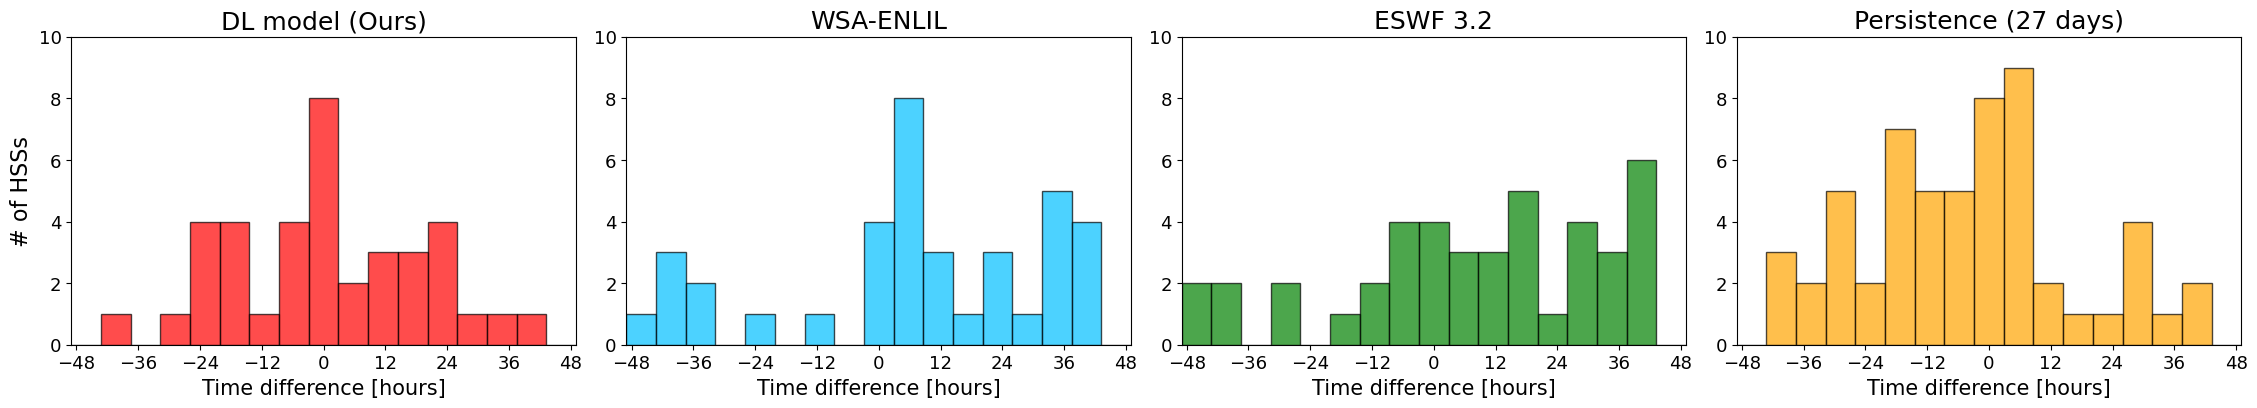

In [24]:
bins = np.linspace(-49, 49, 18)

fig, ax = plt.subplots(1, 4, figsize=(28, 4))
fig.subplots_adjust(wspace=0.1)

data_hours = [td.total_seconds() / 3600 for td in model_hists]
ax[0].hist(data_hours, bins=bins, color='r', edgecolor='black', alpha=0.7)
ax[0].set_xlim([-49, 49])
ax[0].set_ylim([0, 10])
ax[0].set_xticks([-48, -36, -24, -12, 0, 12, 24, 36, 48])
ax[0].tick_params(axis='x', labelsize=13)
ax[0].tick_params(axis='y', labelsize=13)
ax[0].set_xlabel("Time difference [hours]", fontsize = 15)
ax[0].set_ylabel("# of HSSs", fontsize = 16)
ax[0].set_title("DL model (Ours)", fontsize = 18)

data_hours = [td.total_seconds() / 3600 for td in wsa_hists]
ax[1].hist(data_hours, bins=bins, color='deepskyblue', edgecolor='black', alpha=0.7)
ax[1].set_xlim([-49, 49])
ax[1].set_ylim([0, 10])
ax[1].set_xticks([-48, -36, -24, -12, 0, 12, 24, 36, 48])
ax[1].tick_params(axis='x', labelsize=13)
ax[1].tick_params(axis='y', labelsize=13)
ax[1].set_xlabel("Time difference [hours]", fontsize = 15)
#ax[1].set_ylabel("# of HSSs")
ax[1].set_title("WSA-ENLIL", fontsize = 18)

data_hours = [td.total_seconds() / 3600 for td in eswf_hists]
ax[2].hist(data_hours, bins=bins, color='g', edgecolor='black', alpha=0.7)
ax[2].set_xlim([-49, 49])
ax[2].set_ylim([0, 10])
ax[2].set_xticks([-48, -36, -24, -12, 0, 12, 24, 36, 48])
ax[2].tick_params(axis='x', labelsize=13)
ax[2].tick_params(axis='y', labelsize=13)
ax[2].set_xlabel("Time difference [hours]", fontsize = 15)
#ax[2].set_ylabel("# of HSSs")
ax[2].set_title("ESWF 3.2", fontsize = 18)

data_hours = [td.total_seconds() / 3600 for td in persistence_hists]
ax[3].hist(data_hours, bins=bins, color='orange', edgecolor='black', alpha=0.7)
ax[3].set_xlim([-49, 49])
ax[3].set_ylim([0, 10])
ax[3].set_xticks([-48, -36, -24, -12, 0, 12, 24, 36, 48])
ax[3].tick_params(axis='x', labelsize=13)
ax[3].tick_params(axis='y', labelsize=13)
ax[3].set_xlabel("Time difference [hours]", fontsize = 15)
#ax[3].set_ylabel("# of HSSs")
ax[3].set_title("Persistence (27 days)", fontsize = 18)

title_str = "Histogram of time differences with persistence model"
save_path = "E:\\Research\\SWspeed\\Visualization_2012-2020\\plot_images\\\\{}.png".format(title_str)
plt.savefig(save_path, dpi=300, bbox_inches='tight')  # Save figure

plt.show()